Libraries and utility functions are in the attaced file *paper_utils.R*. 

The following R packages have custom code and are installable from github/immunogenomics: 

    singlecellmethods
    wilcoxauc
    harmony


In [1]:
name_clusters <- function(name_list, clusters) {
        cluster_labels <- Reduce(rbind, lapply(names(name_list), function(y) {
            data.table(cell_type = y, cluster_ids = name_list[[y]])
        }))
        data.table(cluster_ids = clusters) %>%
            dplyr::left_join(cluster_labels, by = "cluster_ids") %>% 
            dplyr::select(-cluster_ids) %>% 
            with(cell_type)
}

In [2]:
source("paper_utils.R")
use_python("/PHShome/ik936/anaconda3/bin/python")
umap <- import("umap")


In [3]:
library(harmony)
library(wilcoxauc)
library(singlecellmethods)



Attaching package: ‘wilcoxauc’

The following objects are masked _by_ ‘.GlobalEnv’:

    fast_diff_exp, fast_wilcox



In [4]:
cachedir <- "/data/srlab/ik936/NOTCH/data/cache/"

# Preprocessing

In [7]:
ngene_min <- 1000
numi_max <- 12000
mt_max <- .1

## 10X Tissue

In [8]:
manifest <- list(
    # Primary tissue samples
    batch1 = list(dir.erisone = "/data/srlab/roche/Kevin-Wei/10xgenomics/2017-03-24/",
                  sample.names = c("BWH075", "BWH078")),
    batch2 = list(
        dir.erisone = "/data/srlab/roche/Kevin-Wei/10xgenomics/2017-02-10/",
        sample.names = c("BWH076CD45n")),
    batch3 = list(
        dir.erisone = "/data/srlab/ik936/bwh10x/180130_NB501431_0536_AH737VBGX3/",
        sample.names = c("BWH064CD45n", "OA180104A", "OA180108B")),
    batch4 = list(
        dir.erisone = "/data/srlab/ik936/bwh10x/180209_KW5270_10x_rawbcl/",
        sample.names = c("OA213CD45n", "OA214LCD45n", "RA174CD45n", "RA178CD45n_try2")),
    batch5 = list(
        dir.erisone = "/data/srlab/ik936/bwh10x/180521_KW5625_10x_rawbcl/",
        sample.names = c("OA180430_CD45n_BRI039", "OA180507_CD45n_BRI041")
    ),
    # Micromass samples
    batch6 = list(
        dir.erisone = "/data/srlab/bwh10x/180924_KW6091_10x_rawbcl/",
        sample.names = c("180924_KW6091_10x_BRI-066", "180924_KW6091_10x_BRI-067")
    )
    
)
file.paths <- lapply(manifest, function(batch.list) {
    paste(batch.list$dir.erisone, batch.list$sample.names, sep = "/")
}) %>% unlist() %>% as.character()

In [9]:
file.paths

[1] "/data/srlab/roche/Kevin-Wei/10xgenomics/2017-03-24//BWH075"              
 [2] "/data/srlab/roche/Kevin-Wei/10xgenomics/2017-03-24//BWH078"              
 [3] "/data/srlab/roche/Kevin-Wei/10xgenomics/2017-02-10//BWH076CD45n"         
 [4] "/data/srlab/ik936/bwh10x/180130_NB501431_0536_AH737VBGX3//BWH064CD45n"   
 [5] "/data/srlab/ik936/bwh10x/180130_NB501431_0536_AH737VBGX3//OA180104A"     
 [6] "/data/srlab/ik936/bwh10x/180130_NB501431_0536_AH737VBGX3//OA180108B"     
 [7] "/data/srlab/ik936/bwh10x/180209_KW5270_10x_rawbcl//OA213CD45n"           
 [8] "/data/srlab/ik936/bwh10x/180209_KW5270_10x_rawbcl//OA214LCD45n"          
 [9] "/data/srlab/ik936/bwh10x/180209_KW5270_10x_rawbcl//RA174CD45n"           
[10] "/data/srlab/ik936/bwh10x/180209_KW5270_10x_rawbcl//RA178CD45n_try2"      
[11] "/data/srlab/ik936/bwh10x/180521_KW5625_10x_rawbcl//OA180430_CD45n_BRI039"
[12] "/data/srlab/ik936/bwh10x/180521_KW5625_10x_rawbcl//OA180507_CD45n_BRI041"
[13] "/data/srlab/bwh10x/180924_KW6091_10x_rawbcl//180924_KW6091_10x_BRI-066"  
[14] "/data/srlab/bwh10x/180924_KW6091_10x_rawbcl//180924_KW6091_10x_BRI-067"

In [8]:
dir_names <- file.path(file.paths, "outs/filtered_gene_bc_matrices/hg19")
sample_names <- unlist(strsplit("BWH075,BWH078,BWH076CD45n,BWH064CD45n,OA180104A,OA180108B,OA213CD45n,OA214LCD45n,RA174CD45n,RA178CD45n,OA180430,OA180507,MM1,MM2", ","))


In [11]:
exprs_raw <- Reduce(Matrix::cbind2, lapply(1:length(dir_names), function(i) {
    message(i)
    read10x(dir_names[i], sample_names[i])
}))

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [22]:
meta_raw <- data.frame(cell_id = colnames(exprs_raw)) %>% 
    dplyr::mutate(donor = gsub("^(.*)_(.*)", "\\2", cell_id))
table(meta_raw$donor)

meta_raw$nUMI <- Matrix::colSums(exprs_raw)
meta_raw$nGene <- Matrix::colSums(exprs_raw > 0)
mito_genes <- grep("^MT-", rownames(exprs_raw), value = TRUE, ignore.case = TRUE)
meta_raw$percent_mito <- Matrix::colSums(exprs_raw[mito_genes, ])/Matrix::colSums(exprs_raw)


BWH064CD45n      BWH075 BWH076CD45n      BWH078         MM1         MM2 
       5220        3949        2810        3207        5297        2708 
  OA180104A   OA180108B    OA180430    OA180507  OA213CD45n OA214LCD45n 
       1082        3345        2738        3951        5611        5938 
 RA174CD45n  RA178CD45n 
       3786        3101 

In [25]:
meta_raw %<>% 
    dplyr::mutate(
        ## label disease only for primary tissue
        disease = case_when(
            grepl("^OA", donor) ~ "oa",
            grepl("^BWH|^RA", donor) ~ "ra"
        ),
        ## label source, either primary tissue, or cultured organoid
        source = case_when(
            grepl("^MM", donor) ~ "culture",
            TRUE ~ "primary"
        )
    )

meta_data <- subset(meta_raw, nGene > ngene_min & nUMI < numi_max & percent_mito < mt_max)
nrow(meta_raw); nrow(meta_data)
table(meta_data$donor)

[1] 52743

[1] 41565


BWH064CD45n      BWH075 BWH076CD45n      BWH078         MM1         MM2 
       4454        3249        2447        2121        4336        2076 
  OA180104A   OA180108B    OA180430    OA180507  OA213CD45n OA214LCD45n 
        618        2695        1823        2624        4759        4544 
 RA174CD45n  RA178CD45n 
       3368        2451 

In [27]:
meta_data %>% head

cell_id,donor,nUMI,nGene,percent_mito,disease,source
AAACCTGAGACAAAGG_BWH075,BWH075,3304,1265,0.06174334,ra,primary
AAACCTGAGACTGTAA_BWH075,BWH075,9223,2364,0.02060067,ra,primary
AAACCTGAGGTAGCCA_BWH075,BWH075,5198,1789,0.05790689,ra,primary
AAACCTGCAATCTGCA_BWH075,BWH075,2957,1156,0.07203247,ra,primary
AAACCTGCATCGACGC_BWH075,BWH075,4506,1769,0.03284510,ra,primary
AAACCTGCATTATCTC_BWH075,BWH075,4198,1448,0.01619819,ra,primary


In [45]:
genes_use <- which(Matrix::rowSums(exprs_raw[, meta_data$cell_id] != 0) >= 10)
exprs_norm <- exprs_raw[genes_use, meta_data$cell_id] %>% normalizeData()

## (CACHE)

In [51]:
exprs_raw %>% saveRDS(file.path(cachedir, "exprs_raw_sc.rds"))
exprs_norm %>% saveRDS(file.path(cachedir, "exprs_norm_sc.rds"))
meta_raw %>% saveRDS(file.path(cachedir, "meta_raw_sc.rds")) 
meta_data %>% saveRDS(file.path(cachedir, "meta_data_sc.rds"))

# SC Tissue alone

In [5]:
exprs_norm <- readRDS(file.path(cachedir, "exprs_norm_sc.rds"))
meta_data <- readRDS(file.path(cachedir, "meta_data_sc.rds"))

In [71]:
idx_tissue <- which(meta_data$source == "primary")
tissue <- list()
tissue$meta_data <- meta_data[idx_tissue, ]
tissue$exprs_norm <- exprs_norm[, idx_tissue]

In [457]:
with(tissue, {
    vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$donor)
    var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])
    
    message(length(var_genes))
    exprs_cosine <- exprs_norm[var_genes, ] %>% singlecellmethods::scaleData()# %>% cosine_normalize_cpp(2)
    system.time({
        pca_res <- rARPACK::svds(exprs_cosine, 50, 0, 50)
        V <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")
    })
    system.time({
        umap_res <- umap$UMAP(n_neighbors = 30L, metric = "correlation", min_dist = .1)$fit_transform(V)
    })
    
    tissue$pca_res <<- pca_res
    tissue$V <<- V
    tissue$umap <<- umap_res    
})


3299


## Harmony

Harmony 1/3
Harmony 2/3
Harmony 3/3


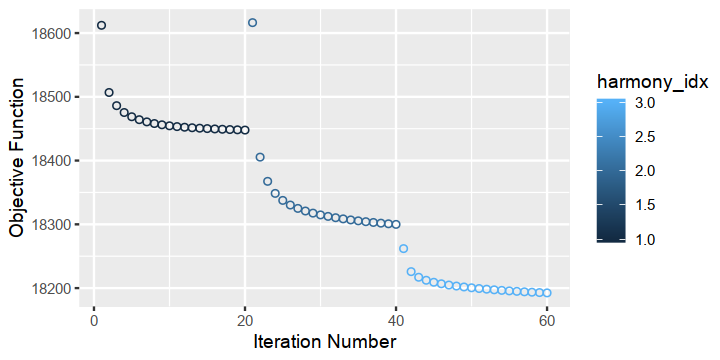

In [122]:
fig.size(3, 6)
with(tissue, {
    harmonyObj <- HarmonyMatrix(V, meta_data, c("donor"), theta = c(1), 
                                 lambda = c(1), epsilon.harmony = -Inf,
                                 max.iter.cluster = 20, max.iter.harmony = 3, sigma = .05,
                                 nclust = 100, plot_convergence = TRUE, return_object = TRUE, 
                                 dist_type = 1, update_online = FALSE) ## 0: Euclidean distance, 1: cosine distance

    tissue$Z_cos <<- harmonyObj$Z_cos
    tissue$Z_corr <<- harmonyObj$Z_corr
    tissue$R <<- harmonyObj$R
    umap <- import("umap")    
    tissue$umap_harmony <<- umap$UMAP(n_neighbors = 30L, metric = "correlation", min_dist = .1)$fit_transform(t(harmonyObj$Z_cos))  
})

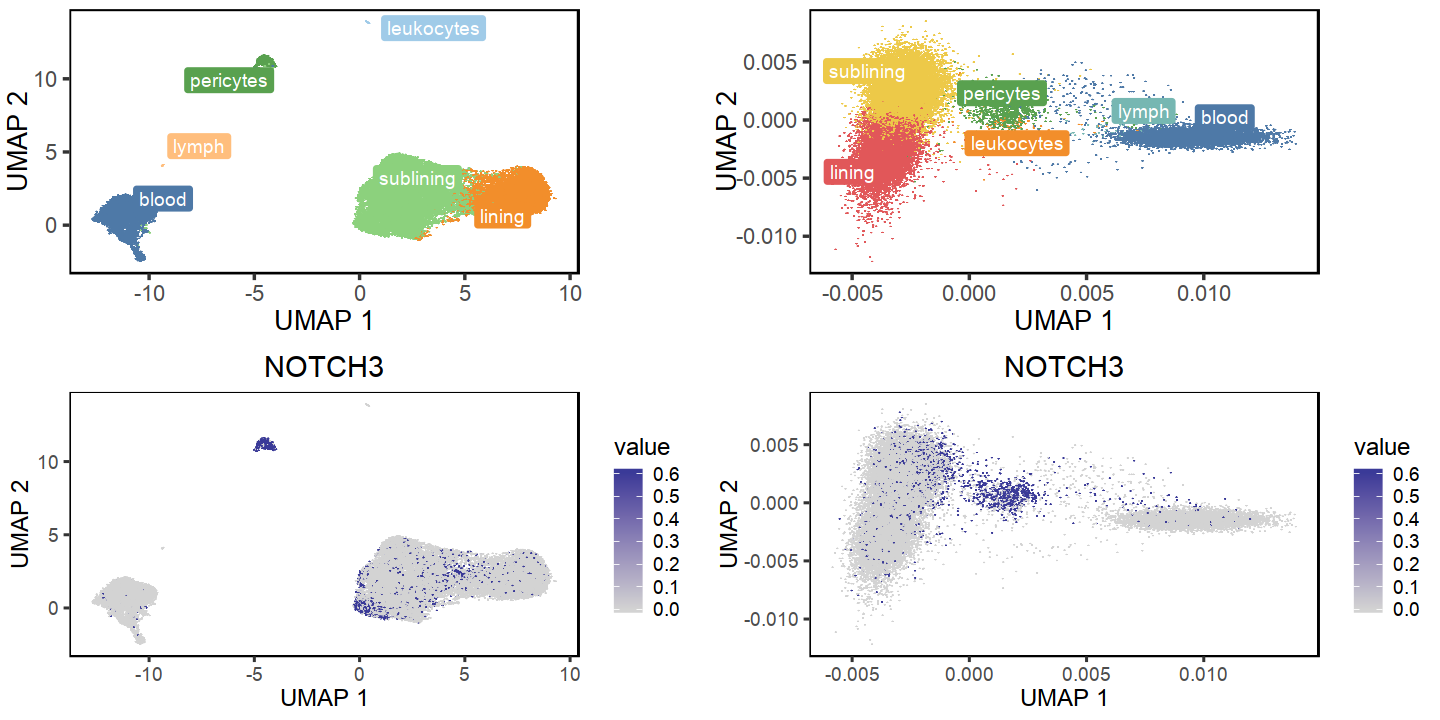

In [565]:
fig.size(6, 12)
with(tissue, {
    do_scatter(umap_harmony, meta_data, "cell_type", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(6), do_labels = TRUE) + 
    do_scatter(t(Z_corr), meta_data, "cell_type", pt_size = 4, 
                              palette_use = tableau_color_pal("Tableau 10")(6), do_labels = TRUE) + 
    plotFeatures(exprs_norm, umap_harmony, order_by_expression = FALSE, no_guide = FALSE,
                 'NOTCH3', nrow = 1, qlo = .02, qhi = .8) + 
    plotFeatures(exprs_norm, t(Z_corr), order_by_expression = FALSE, no_guide = FALSE,
                 'NOTCH3', nrow = 1, qlo = .02, qhi = .8) + 
    NULL
})


## Label cell types

Clustering with Leiden

In [64]:
with(tissue, {
    tissue$snn <<- singlecellmethods:::buildSNN_fromFeatures(
        t(Z_cos), prune_snn = 1/15, nn_k = 30, nn_eps = 0
    )
})        


   user  system elapsed 
103.287   0.166 103.603 

In [66]:
with(tissue, {
    tissue$ids_ref <<- singlecellmethods:::leidenCluster(
        snn, c(.005, .015), min_cluster_size = 10, verbose = TRUE, 
        pythondir = "/PHShome/ik936/anaconda3/bin/python")    
})

Resolution 0.005000 yielded 5 clusters
Resolution 0.015000 yielded 8 clusters


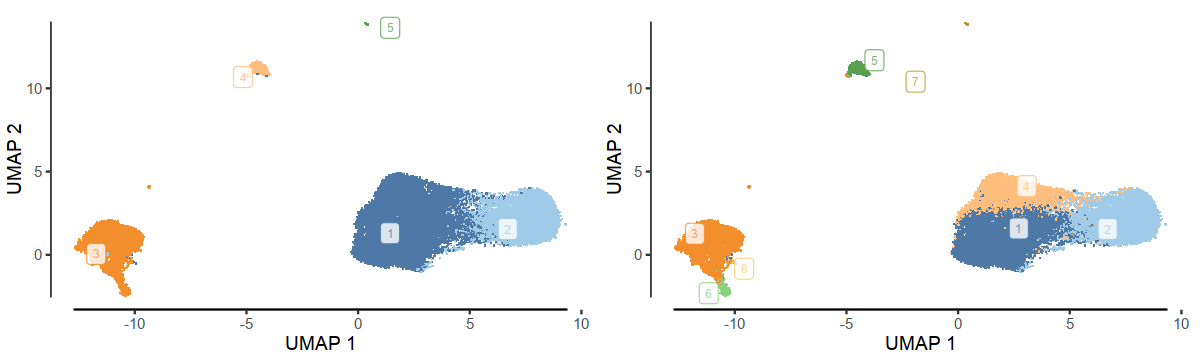

In [67]:
fig.size(3, 10)
with(tissue, {
    Reduce(`+`, apply(ids_ref, 2, function(x) {
        plot_clusters3(x, pt_size = 2.5, do_labels = TRUE, umap_use = umap_harmony, min_cluster_size = 10) 
    })) %>% plot()
})


Endothelial cells can be split further - lymphatic and blood vessel 

In [101]:
with(tissue, {
    tissue$meta_data$clusters <<- ids_ref[, 1]
    idx_lymphatic <- which(umap_harmony[, 2] < 5 & umap_harmony[, 2] > 3 & umap_harmony[, 1] > -10 & umap_harmony[, 1] < -9)
    tissue$meta_data$clusters[idx_lymphatic] <<- 1 + max(clusters)
})


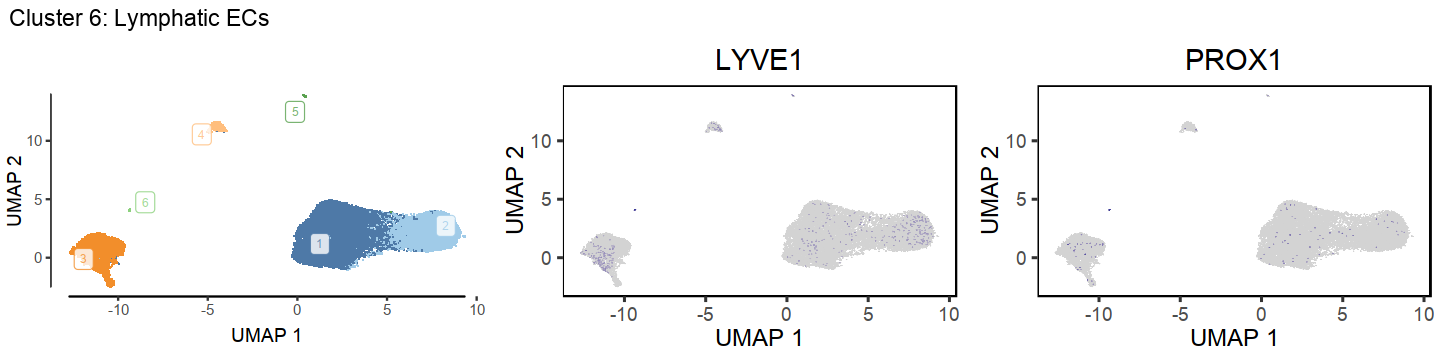

In [107]:
fig.size(3, 12)
features <- c("LYVE1", "PROX1")
with(tissue, {
    plot_clusters3(meta_data$clusters, pt_size = 2.5, do_labels = TRUE, umap_use = umap_harmony, min_cluster_size = 10) +    
    plotFeatures(exprs_norm, umap_harmony, order_by_expression=TRUE, no_guide=TRUE,
                 features, nrow=1, qlo=0, qhi=1) + 
    plot_layout(widths = c(.5, 1)) + 
    plot_annotation(title = "Cluster 6: Lymphatic ECs") + 
    NULL
})


DGE with Mann-Whitney and AUC

In [112]:
tissue$meta_data %>% head

cell_id,donor,nUMI,nGene,percent_mito,disease,source,clusters
AAACCTGAGACAAAGG_BWH075,BWH075,3304,1265,0.06174334,ra,primary,2
AAACCTGAGACTGTAA_BWH075,BWH075,9223,2364,0.02060067,ra,primary,3
AAACCTGAGGTAGCCA_BWH075,BWH075,5198,1789,0.05790689,ra,primary,1
AAACCTGCAATCTGCA_BWH075,BWH075,2957,1156,0.07203247,ra,primary,1
AAACCTGCATCGACGC_BWH075,BWH075,4506,1769,0.03284510,ra,primary,3
AAACCTGCATTATCTC_BWH075,BWH075,4198,1448,0.01619819,ra,primary,2


In [113]:
# name_list <- list(leukocytes = 5, pericytes = 4, endothelial = 3, lining = 2, sublining = 1)
name_list <- list(leukocytes = 5, 
                  pericytes = 4, 
                  blood = 3,
                  lymph = 6,
                  lining = 2,
                  sublining = 1)


tissue$meta_data$cell_type <- name_clusters(name_list, tissue$meta_data$clusters)
# name_clusters(name_list, ids_ref$`res_1.5000e-02`) %>% table
# name_clusters(name_list, ids_ref$`res_1.5000e-02`) %>% is.na %>% table

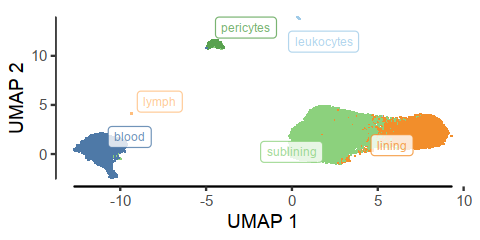

In [116]:
fig.size(2, 4)
with(tissue, {
    plot_clusters3(meta_data$cell_type, pt_size = 2.5, do_labels = TRUE, umap_use = umap_harmony, min_cluster_size = 10)
})


## DGE

In [121]:
sum(is.na(tissue$meta_data$cell_type))
with(tissue, {
    genes_use <- which(Matrix::rowSums(exprs_norm != 0) >= 5)
    tissue$markers <<- wilcoxauc::fast_diff_exp(exprs_norm[genes_use, ], factor(meta_data$cell_type))
})


[1] 0

## Pseudotime

### DDRTree

In [8]:
library(DDRTree)

Loading required package: irlba


In [453]:
with(tissue, {
#     idx_fibro <- which(meta_data$cell_type %in% c('pericytes', "lining", "sublining"))
    idx_fibro <- which(meta_data$cell_type %in% c("lining", "sublining"))
    harmony_Z <- Z_cos[, idx_fibro]    
    colnames(harmony_Z) <- meta_data$cell_id[idx_fibro]
    ncells <- ncol(harmony_Z)
    ncenter <- round(2 * 100 * log(ncells) / (log(ncells) + log(100)))
    ddr_args <- c(list(
        X = harmony_Z, 
        dimensions = 2, ## LOW DIMENSIONALITY
        ncenter = ncenter, 
        verbose = FALSE))

    ddrtree_res <- do.call(DDRTree, ddr_args)
    ddrtree_res$Z <- t(ddrtree_res$Z)
    row.names(ddrtree_res$Z) <- meta_data$cell_id[idx_fibro]    
    tissue$ddrtree_res <<- ddrtree_res
})



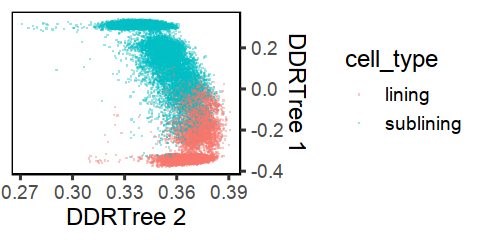

In [780]:
fig.size(2, 4)
data.frame(tissue$ddrtree_res$Z) %>% 
    cbind(tissue$meta_data %>% subset(cell_type %in% c("lining", "sublining"))) %>%
    ggplot(aes(X1, X2)) + 
        geom_point(shape = ".", aes(color = cell_type), alpha = .4) + 
        theme_tufte(base_size = 14) + 
        theme(panel.background = element_rect()) + 
        labs(x = "DDRTree 2", y = "DDRTree 1") + 
        scale_y_continuous(position = "right") + 
        NULL



### Principal Curve

    For consistency, set lining to be position=100

In [424]:
library(princurve)
## 1.5 minutes
pc_res <- princurve::principal_curve(ddrtree_res$Z)
pc_res$lambda <- scales::rescale(pc_res$lambda) * 100

with(tissue, {
    idx_fibro <- which(meta_data$cell_type %in% c("lining", "sublining"))
    tissue$meta_data[idx_fibro, "time"] <<- as.numeric(pc_res$lambda)
})

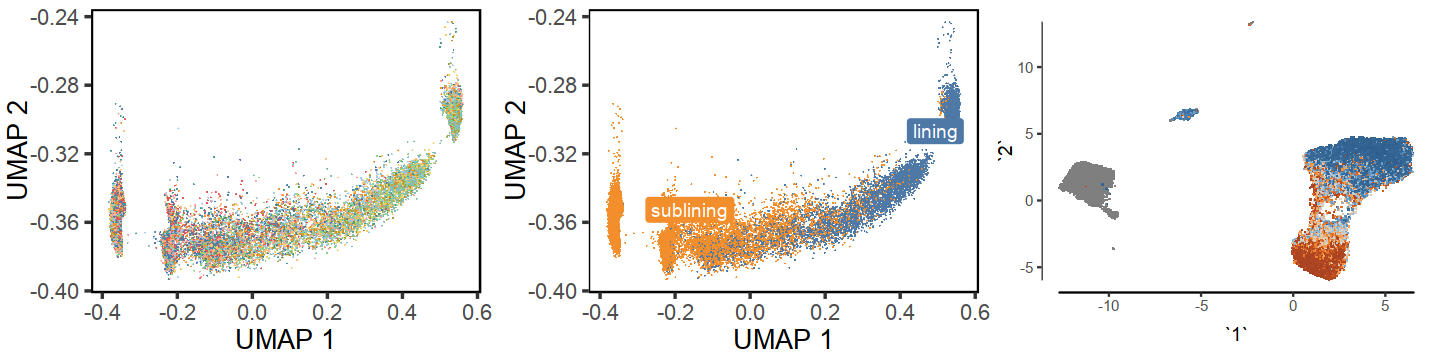

In [425]:
fig.size(3, 12)
with(tissue, {
    idx_fibro <- which(meta_data$cell_type %in% c("lining", "sublining"))
    do_scatter(ddrtree_res$Z, meta_data[idx_fibro, ], "donor", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(12), do_labels = FALSE) + 
    do_scatter(ddrtree_res$Z, meta_data[idx_fibro, ], "cell_type", pt_size = 4, 
                              palette_use = tableau_color_pal("Tableau 10")(6), do_labels = TRUE) + 
    umap_harmony %>% 
        cbind(meta_data) %>% 
        ggplot(aes(`1`, `2`, color = time)) + geom_point(shape = '.') + 
            theme_tufte() + geom_rangeframe(color = "black") + scale_color_gradient2_tableau() + 
            guides(color = FALSE) 
})


Warning message:
“Removed 7153 rows containing non-finite values (stat_density).”

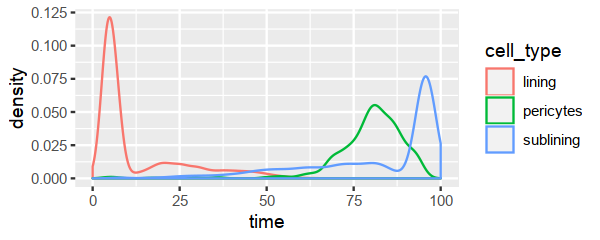

In [368]:
fig.size(2, 5)
with(tissue, {
    meta_data %>% ggplot(aes(time, color = cell_type)) + geom_density()
})

### Project pericytes

In [371]:
with(tissue, {
    idx_peri <- which(meta_data$cell_type == "pericytes")
    idx_fibro <- which(meta_data$cell_type %in% c("lining", "sublining"))
    knn_peri <- RANN::nn2(t(Z_cos[, idx_fibro]), t(Z_cos[, idx_peri]), k = 10, eps = 0)    
    
    time_pericytes <- Reduce(rbind, lapply(1:nrow(knn_peri$nn.idx), function(i) {
        nn_dist <- knn_peri$nn.dists[i, ]
        nn_dist <- exp(-nn_dist / .1)
        nn_dist %<>% prop.table()
        nn_pseudotime <- meta_data[idx_fibro, 'time'][knn_peri$nn.idx[i, ]]
        sum(nn_dist * nn_pseudotime)
#         umap_harmony[knn$nn.idx[i, ], ] %>% sweep(1, nn_dist, `*`) %>% colSums
    }))
    tissue$meta_data[idx_peri, "time"] <<- as.numeric(time_pericytes)    
})


In [11]:
fig.size(3, 5)
with(tissue, {
    do_scatter(t(Z_cos), meta_data, "cell_type", pt_size = 4,
               palette_use = tableau_color_pal("Tableau 20")(7), do_labels = TRUE)
    
})


ERROR: Error in with(tissue, {: object 'tissue' not found


In [ ]:
fig.size(3, 8)
with(tissue, {
    plotFeatures(exprs_norm, t(Z_cos), order_by_expression = FALSE, no_guide = FALSE,
                 'NOTCH3', nrow = 1, qlo = .02, qhi = .8) + 
    t(Z_cos) %>%  data.frame() %>% 
        cbind(meta_data) %>% 
        ggplot(aes(`X1`, `X2`, color = time)) + geom_point(shape = '.') + 
            theme_tufte() + geom_rangeframe(color = "black") + scale_color_gradient2_tableau() + 
            guides(color = FALSE) 
    
})


#### prioritize trajectory associated genes

In [14]:
with(tissue, {
    idx_use <- which(meta_data$cell_type %in% c('lining', 'sublining'))
    design <- model.matrix(~time + donor, meta_data[idx_use, ])
    limma_res <<- exprs_norm[, idx_use] %>% 
        limma::lmFit(design) %>% 
        limma::eBayes() %>% 
        limma::topTable(coef = 2, number = 1e4)     
})


Warning message:
“Zero sample variances detected, have been offset away from zero”

In [15]:
limma_res %>% head
limma_res %>% subset(adj.P.Val < 1e-5) %>% nrow
nrow(limma_res)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CRTAC1,-0.02535226,2.221786,-155.3728,0,0,8626.581
CXCL12,0.02569940,1.914927,152.0693,0,0,8354.817
FN1,-0.01946700,3.967040,-149.2189,0,0,8120.710
PRG4,-0.02608089,3.156762,-138.5637,0,0,7250.303
HTRA1,-0.01982069,2.210146,-128.1968,0,0,6414.496
DCN,0.01852725,3.348057,126.1510,0,0,6251.321


[1] 4809

[1] 10000

In [244]:
tissue$axis_associated_genes <- limma_res

In [250]:
tissue$axis_associated_genes %>% 
    data.frame() %>% 
    tibble::rownames_to_column('symbol') %>% 
    dplyr::arrange(-abs(t)) %>% 
    tibble::rowid_to_column('rank') %>% 
    subset(symbol == 'CDH11')


,rank,symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
450,450,CDH11,0.002354201,0.2656584,26.76137,9.478355e-156,4.278951e-154,339.7773


In [257]:
library(presto)
wilcoxauc(tissue$exprs_norm[c('THY1', 'CDH11'), , drop = FALSE], tissue$meta_data$cell_type, c('lining', 'sublining'))

feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDH11,lining,0.1102263,-0.2573137,70354150,0.3971278,0,0,9.586117,29.793187
CDH11,sublining,0.3675401,0.2573137,106803290,0.6028722,0,0,29.793187,9.586117
THY1,lining,0.2852326,-1.2257390,36578729,0.2064758,0,0,16.629547,71.745742
THY1,sublining,1.5109715,1.2257390,140578711,0.7935242,0,0,71.745742,16.629547


In [269]:
with(tissue, {
    data_df <- meta_data %>% 
        cbind(val = exprs_norm['CDH11', ]) %>% 
        subset(cell_type %in% c('lining', 'sublining')) %>%
        with(cor.test(~ val + time, method = 'spearman')) %>% 
        broom::tidy() %>% 
        print()

#     model_full <<- lmer(val ~ 1 + time + (1|donor), data_df)
#     model_null <<- lmer(val ~ 1 + (1|donor), data_df)
    
})

Warning message in cor.test.default(x = c(0, 0, 0, 0, 1.49802023208233, 0, 0, 0, :
“Cannot compute exact p-value with ties”

# A tibble: 1 x 5
  estimate statistic p.value method                          alternative
     <dbl>     <dbl>   <dbl> <chr>                           <chr>      
1    0.240   2.55e12       0 Spearman's rank correlation rho two.sided  


In [253]:
names(tissue$markers)

[1] "auc"      "fdr"      "pct_in"   "pct_out"  "means"    "means_nz" "lfc"

In [254]:
tissue$markers$lfc['CDH11', ]

,blood,leukocytes,lining,lymph,pericytes,sublining
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDH11,-0.2367882,-0.1301104,-0.1482913,-0.1841937,-0.1049341,0.2899524


#### Use only those genes to project pericytes

1000
Harmony 1/5
Harmony 2/5
Harmony 3/5
Harmony 4/5
Harmony 5/5


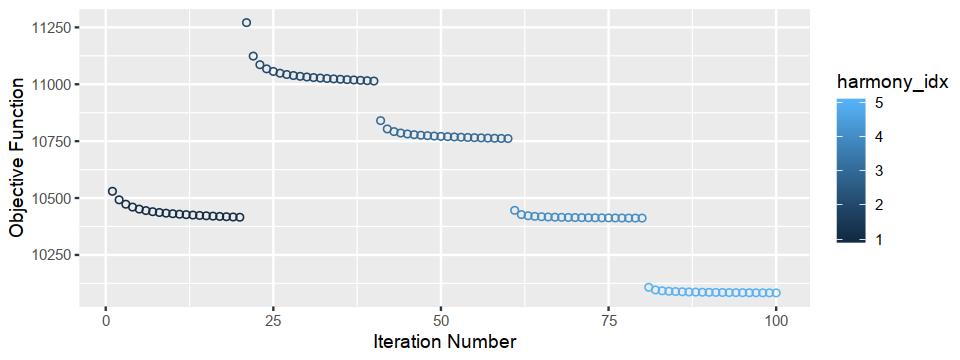

In [450]:
with(tissue, {
#     vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$donor)
#     var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])
    var_genes <- limma_res %>% subset(adj.P.Val < 1e-5) %>% head(1000) %>% row.names()
    message(length(var_genes))
    idx_use <- which(meta_data$cell_type %in% c("pericytes", 'lining', 'sublining'))
    
    
    
    exprs_cosine <- exprs_norm[var_genes, idx_use] %>% singlecellmethods::scaleData()# %>% cosine_normalize_cpp(2)
    system.time({
        pca_res <- rARPACK::svds(exprs_cosine, 50, 0, 50)
        V <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")
    })
#     umap <- import("umap")    
#     umap_res <- umap$UMAP(n_neighbors = 30L, metric = "correlation", min_dist = .1)$fit_transform(V)

    meta_data_tmp <- meta_data[idx_use, ]
    meta_data_tmp %<>% dplyr::mutate(tmp = ifelse(cell_type == 'pericytes', 'PC', 'FLS'))
    
    tissue$V2 <<- V
    tissue$umap2 <<- umap_res
    harmonyObj <<- HarmonyMatrix(V, meta_data_tmp, c("donor", 'tmp'), theta = c(0, 0), lambda = c(1, 1), 
                                epsilon.harmony = -Inf,
                                max.iter.cluster = 20, max.iter.harmony = 5, sigma = .1,
                                nclust = 100, plot_convergence = TRUE, return_object = TRUE)
    
})


Warning message:
“Removed 7153 rows containing non-finite values (stat_density).”

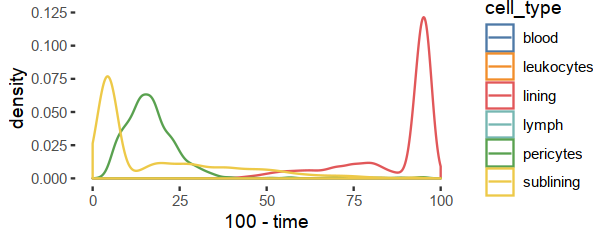

In [390]:
fig.size(2, 5)
with(tissue, {
    meta_data %>% ggplot(aes(100 - time, color = cell_type)) + geom_density() + 
        theme_tufte() + geom_rangeframe() + 
        scale_color_tableau()
})

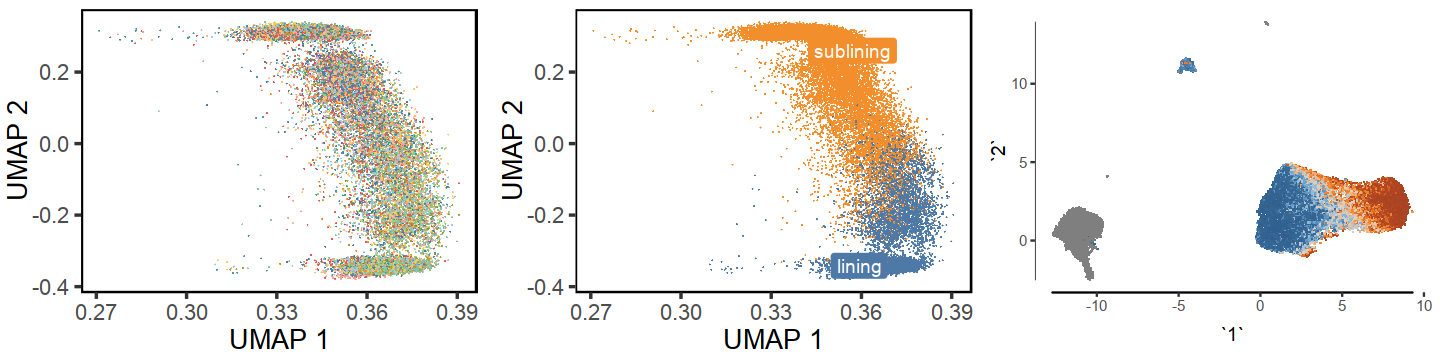

In [13]:
fig.size(3, 12)
with(tissue, {
    idx_fibro <- which(meta_data$cell_type %in% c("lining", "sublining"))
    do_scatter(ddrtree_res$Z, meta_data[idx_fibro, ], "donor", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(12), do_labels = FALSE) + 
    do_scatter(ddrtree_res$Z, meta_data[idx_fibro, ], "cell_type", pt_size = 4, 
                              palette_use = tableau_color_pal("Tableau 10")(6), do_labels = TRUE) + 
    umap_harmony %>% 
        cbind(meta_data) %>% 
        ggplot(aes(`1`, `2`, color = time)) + geom_point(shape = '.') + 
            theme_tufte() + geom_rangeframe(color = "black") + scale_color_gradient2_tableau() + 
            guides(color = FALSE) 
})


### GLM regression

    logit(position) ~ 1 + 

In [ ]:
# markers <- c("THY1", "NOTCH3", "PDGFRA", "PDPN", "CD34", "CD55", "PRG4", "PTPRC")
# with(tissue, {
#     idx_use <- which(!is.na(meta_data$time))
    
#     glm_res <- Reduce(rbind, lapply(markers, function(marker) {
#         message(marker)
#         ldata <- data.frame(value = exprs_norm[marker, idx_use], meta_data[idx_use, ])
#         suppressWarnings({
#             fit_full <- glm(time ~ 1 + value + donor + log(nGene), family = "binomial", data = ldata)
#         })
#         data.table(symbol = marker, subset(broom::tidy(fit_full), term == "value")) 
#     })) %>% 
#         dplyr::mutate(fdr = p.adjust(p.value, "BH")) %>% 
#         dplyr::arrange(fdr, p.value)
    
# })



## (CACHE)

In [122]:
tissue <- readRDS(file.path(cachedir, "analysis_sc_tissue.rds"))


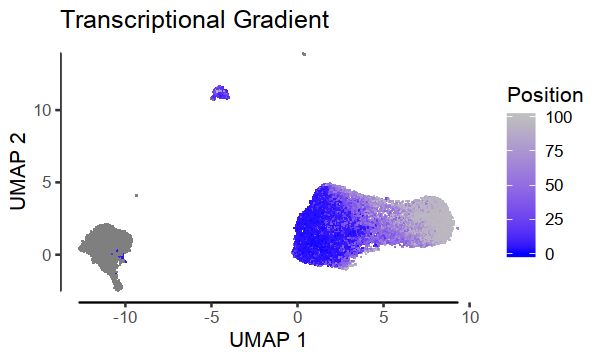

In [100]:
fig.size(3, 5)
tissue$umap_harmony %>%
    cbind(tissue$meta_data) %>% 
    ggplot(aes(`1`, `2`, color = 100 - time)) + 
        geom_point(shape = '.') + 
        scale_color_gradient2(mid = "blue", high = "grey", midpoint = 0) + 
        theme_tufte(base_size = 12, base_family = 'Helvetica') + geom_rangeframe(color = "black") + 
        labs(title = "Transcriptional Gradient", color = "Position", x = "UMAP 1", y = "UMAP 2") + 
        NULL



In [130]:
tissue$meta_data %>% head

cell_id,donor,nUMI,nGene,percent_mito,disease,source,clusters,cell_type,time
AAACCTGAGACAAAGG_BWH075,BWH075,3304,1265,0.06174334,ra,primary,2,lining,24.55933
AAACCTGAGACTGTAA_BWH075,BWH075,9223,2364,0.02060067,ra,primary,3,blood,NA
AAACCTGAGGTAGCCA_BWH075,BWH075,5198,1789,0.05790689,ra,primary,1,sublining,97.77696
AAACCTGCAATCTGCA_BWH075,BWH075,2957,1156,0.07203247,ra,primary,1,sublining,94.76058
AAACCTGCATCGACGC_BWH075,BWH075,4506,1769,0.03284510,ra,primary,3,blood,NA
AAACCTGCATTATCTC_BWH075,BWH075,4198,1448,0.01619819,ra,primary,2,lining,13.16606


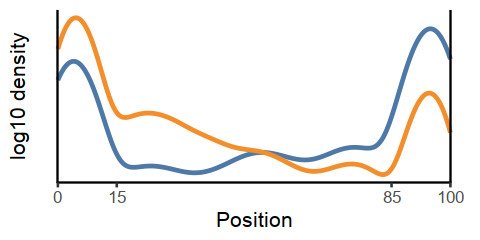

In [172]:
fig.size(2, 4)
tissue$meta_data %>% 
    subset(cell_type %in% c("lining", "sublining")) %>% 
#     dplyr::mutate(time_section = cut(100 - time, c(0, 15, 85, 100), include.lowest = TRUE)) %>% 
    ggplot(aes(100 - time)) + 
        geom_line(stat="density", aes(color = disease), size = 1) + scale_color_tableau() +  
    geom_vline(xintercept = c(0, 100)) + 
#         geom_density(aes(color = disease), size = 1) + scale_color_tableau() + 
#         geom_density(aes(fill = disease), alpha = .4) + scale_fill_tableau() +   
    theme_tufte(base_size = 12, base_family = 'Helvetica') +
    geom_rangeframe(color = "black") + 
    guides(color = FALSE, fill = FALSE) + 
    labs(color = "Position", x = "Position", y = "log10 density") + 
    theme(axis.ticks.y = element_blank(), axis.text.y = element_blank()) + 
#           panel.background = element_rect()) + 
#     scale_x_continuous(breaks = seq(0, 100, 5)) + 
    scale_x_continuous(breaks = c(0, 15, 85, 100)) + 
    scale_y_log10() + 
#     facet_wrap(~time_section, nrow = 1, scales = "free") + 
    NULL


## Disease Pseudotime

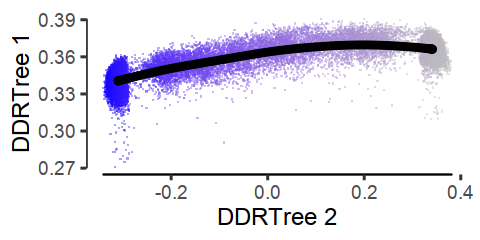

In [652]:
fig.size(2, 4)
data.frame(tissue$ddrtree_res$Z) %>% 
    cbind(tissue$meta_data %>% subset(cell_type %in% c("lining", "sublining"))) %>%
    ggplot(aes(-X2, X1)) + 
#     ggplot(aes(X1, X2)) + 
#         geom_density2d(aes(color = disease)) + 
        geom_point(shape = ".", aes(color = 100 - time), alpha = .4) + 
#         geom_point(shape = ".", aes(color = 100 - time), alpha = .4) + 
        geom_point(data = data.frame(t(tissue$ddrtree_res$Y))) + 
        theme_tufte(base_size = 14) + geom_rangeframe(color = "black") + 
        labs(x = "DDRTree 2", y = "DDRTree 1") + 
#         scale_color_tableau() + 
        scale_color_gradient2(mid = "blue", high = "grey", midpoint = 0) + 
        guides(color = FALSE) + 
#         scale_color_tableau() + 
        NULL
#         geom_point(aes(col = id))
#         geom_point() + geom_link()

# Micromass

In [133]:
joint <- readRDS(file.path(cachedir, "analysis_sc_tissue_mm.rds"))

In [466]:
exprs_norm <- readRDS(file.path(cachedir, "exprs_norm_sc.rds"))
meta_data <- readRDS(file.path(cachedir, "meta_data_sc.rds"))

In [467]:
## join back the cell types learned in the SC tissue analysis
meta_data %<>% left_join(tissue$meta_data)

Joining, by = c("cell_id", "donor", "nUMI", "nGene", "percent_mito", "disease", "source")


## Joint Harmony

In [16]:
joint$V <- readRDS("/data/srlab/ik936/NOTCH/data/tmp_V1.rds")

In [98]:
with(joint, {
    vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$donor)
    var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])

    exprs_cosine <- exprs_norm[var_genes, ] %>% singlecellmethods::scaleData()# %>% cosine_normalize_cpp(2)
    pca_res <- rARPACK::svds(exprs_cosine, 50, 0, 50)
    V <- sweep(pca_res$v, 2, pca_res$d/max(pca_res$d), "*")
#     V <- sweep(pca_res$v, 2, (pca_res$d ^ 2)/(max(pca_res$d ^ 2)), "*")

    joint$V <<- V
    joint$pca_res <<- pca_res
    
})
# system.time({
#     umap_res <- umap$UMAP(n_neighbors = 30L, metric = "correlation", min_dist = .1)$fit_transform(V)
# })


In [39]:
with(joint, {
    umap <- import("umap")    
    joint$umap_res <<- umap$UMAP(n_neighbors = 30L, metric = "correlation", min_dist = .1)$fit_transform(V[, 1:10])
})


Harmony 1/10
Harmony 2/10
Harmony 3/10
Harmony 4/10
Harmony 5/10
Harmony 6/10


Clustered for 15 iterations


Harmony 7/10


Clustered for 19 iterations


Harmony 8/10


Clustered for 19 iterations


Harmony 9/10
Harmony 10/10


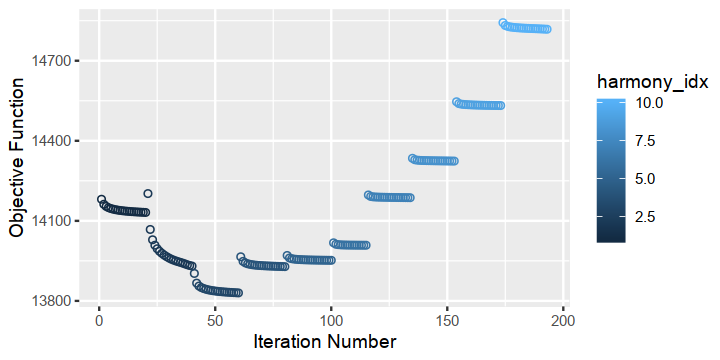

In [154]:
fig.size(3, 6)
with(joint, {
    harmonyObj <<- HarmonyMatrix(V, meta_data, c("donor", "source"), theta = c(.5, .5), 
                                 lambda = c(1, 1), epsilon.harmony = -Inf,
                                 max.iter.cluster = 20, max.iter.harmony = 10, sigma = .05,
                                 nclust = 100, plot_convergence = TRUE, return_object = TRUE, 
                                 dist_type = 1, update_online = FALSE) ## 0: Euclidean distance, 1: cosine distance
})

In [125]:
joint$umap_harmony <- umap$UMAP(n_neighbors = 30L,
                                metric = "correlation", 
                                min_dist = .1, random_state = 1L)$fit_transform(t(harmonyObj$Z_cos))


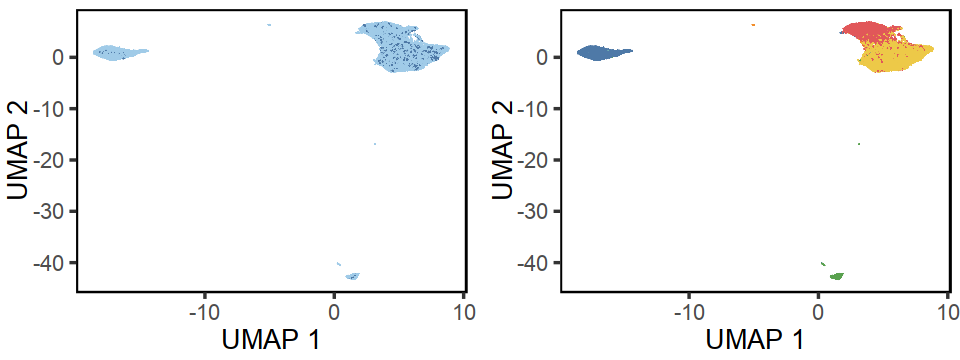

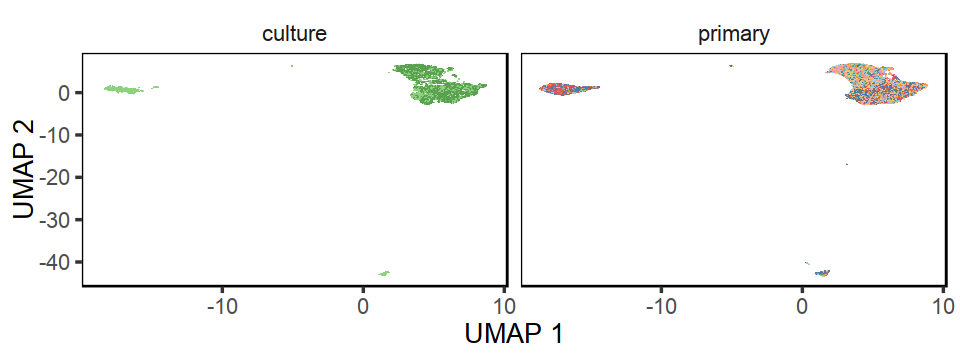

In [126]:
fig.size(3, 8)
with(joint, {
    idx_pr <- which(meta_data$source == 'primary')
    plt <- do_scatter(umap_harmony, meta_data, "source", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(2), do_labels = FALSE) +     
    do_scatter(umap_harmony[idx_pr, ], meta_data[idx_pr, ], "cell_type", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 10")(7), do_labels = FALSE) 
    plot(plt)
    
    do_scatter(umap_harmony, meta_data, "donor", pt_size = 2,
                              palette_use = tableau_color_pal("Tableau 20")(14), do_labels = FALSE) + 
    facet_wrap(~source) + 
    NULL    
})


In [49]:
# (apply(joint$V, 2, sd) * 1000) / sum(apply(joint$V, 2, sd) * 1000)

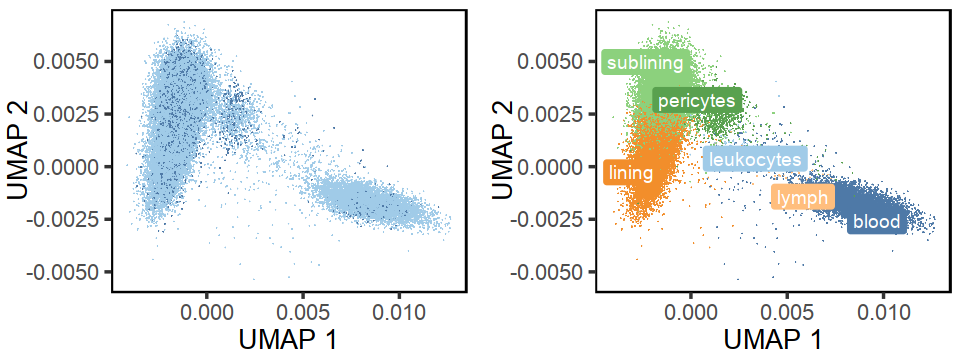

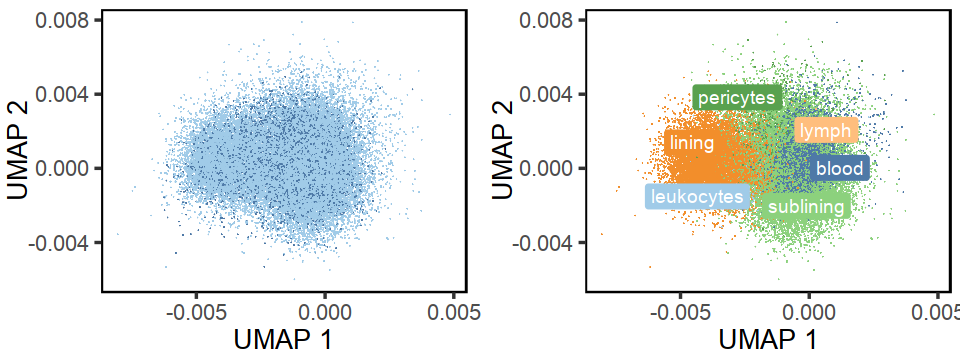

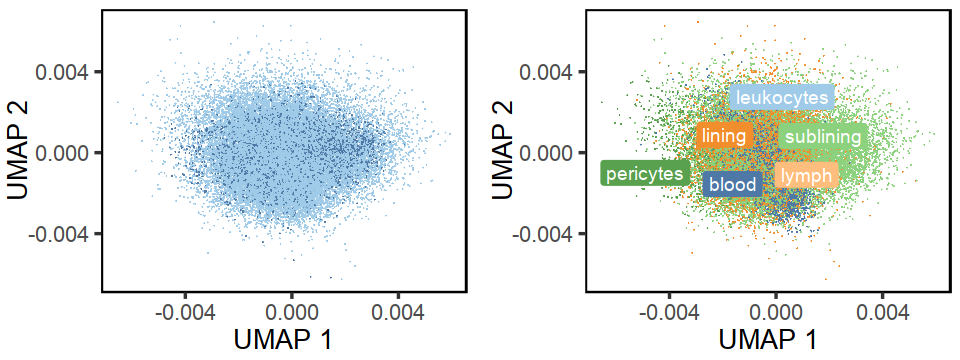

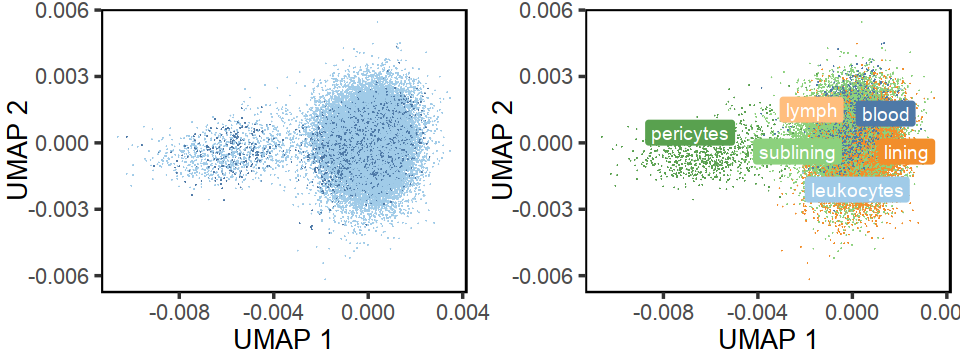

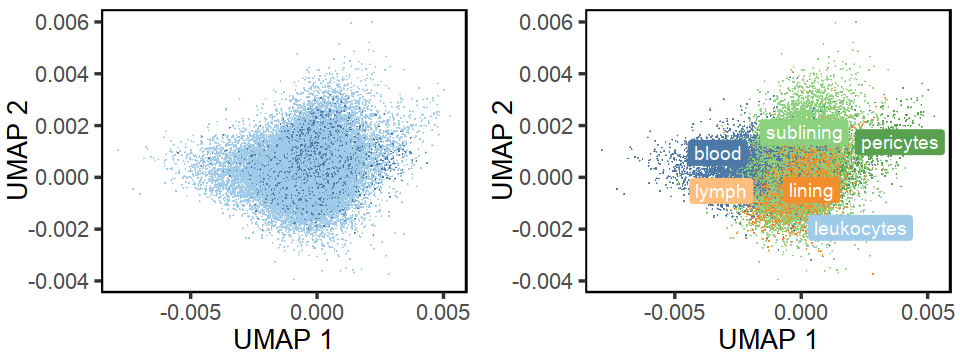

In [127]:
fig.size(3, 8)
with(joint, {
    idx_pr <- which(meta_data$source == 'primary')
    
    ## any dimensions along which MM looks like lining? 
    plt <- do_scatter(t(harmonyObj$Z_corr)[, 1:2], meta_data, "source", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(14), do_labels = FALSE) + 
    do_scatter(t(harmonyObj$Z_corr)[idx_pr, 1:2], meta_data[idx_pr, ], "cell_type", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(7), do_labels = TRUE)
    plot(plt)

    plt <- do_scatter(t(harmonyObj$Z_corr)[, 3:4], meta_data, "source", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(14), do_labels = FALSE) + 
    do_scatter(t(harmonyObj$Z_corr)[idx_pr, 3:4], meta_data[idx_pr, ], "cell_type", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(7), do_labels = TRUE)
    plot(plt)

    plt <- do_scatter(t(harmonyObj$Z_corr)[, 5:6], meta_data, "source", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(14), do_labels = FALSE) + 
    do_scatter(t(harmonyObj$Z_corr)[idx_pr, 5:6], meta_data[idx_pr, ], "cell_type", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(7), do_labels = TRUE)
    plot(plt)

    plt <- do_scatter(t(harmonyObj$Z_corr)[, 7:8], meta_data, "source", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(14), do_labels = FALSE) + 
    do_scatter(t(harmonyObj$Z_corr)[idx_pr, 7:8], meta_data[idx_pr, ], "cell_type", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(7), do_labels = TRUE)
    plot(plt)

    plt <- do_scatter(t(harmonyObj$Z_corr)[, 9:10], meta_data, "source", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(14), do_labels = FALSE) + 
    do_scatter(t(harmonyObj$Z_corr)[idx_pr, 9:10], meta_data[idx_pr, ], "cell_type", pt_size = 4,
                              palette_use = tableau_color_pal("Tableau 20")(7), do_labels = TRUE)
    plot(plt)
    
})



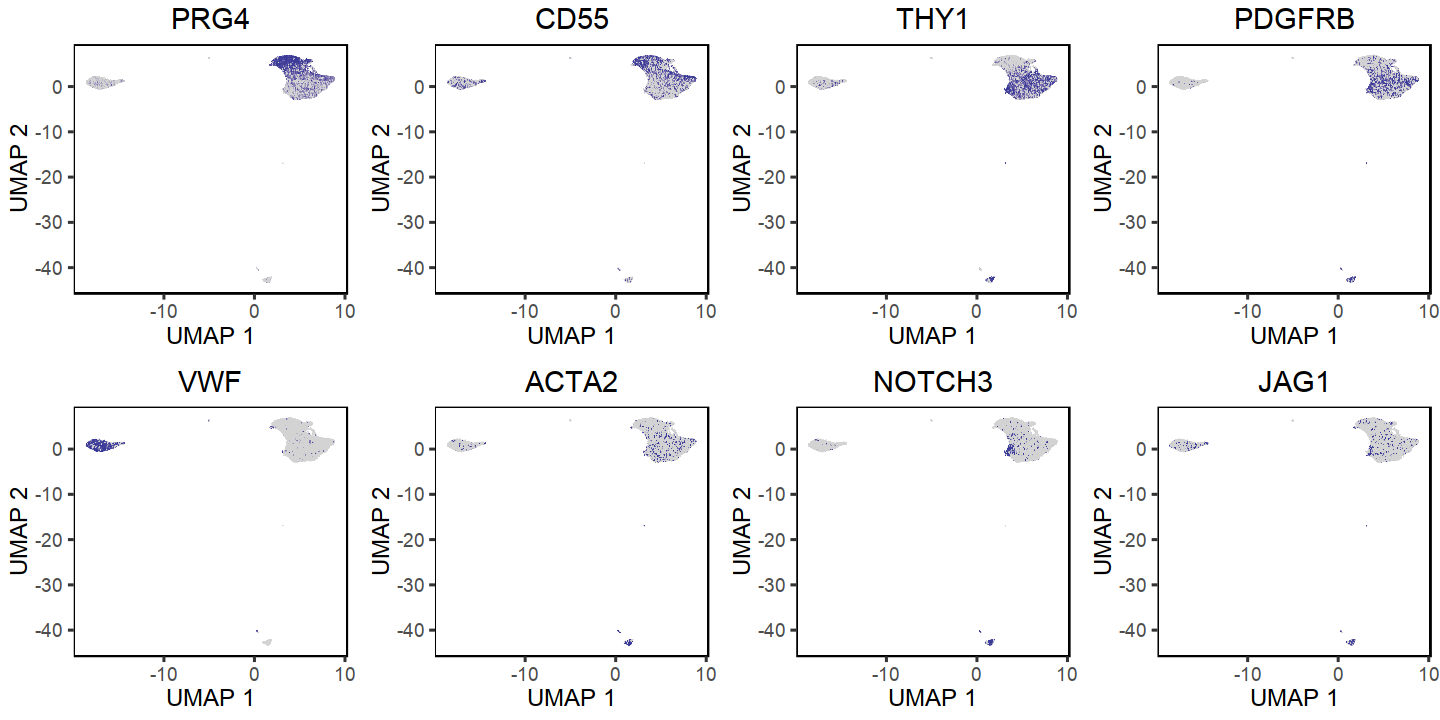

In [128]:
fig.size(6, 12)
# # plotFeatures(exprs_norm, umap_harmony, order_by_expression = TRUE, c("PRG4", "CD55", "THY1", "PDGFRB", "VWF", "ACTA2", "NOTCH3", "JAG1"), nrow = 2, qlo = 0.05, qhi = .9)
with(joint, {
    plotFeatures(exprs_norm, umap_harmony, order_by_expression = FALSE, no_guide = TRUE,
                 c("PRG4", "CD55", "THY1", "PDGFRB", "VWF", "ACTA2", "NOTCH3", "JAG1"), 
                 nrow = 2, qlo = 0.05, qhi = .9)    
})


## Label MM with primary tissue cells

### Project to DDRTree coordinates (Fibroblasts)

In [717]:
with(joint, {
    idx_mm <- which(meta_data$source == "culture")
    # idx_pr <- which(meta_data$source == "primary" & !is.na(meta_data$time))
    idx_pr <- which(meta_data$source == "primary" & meta_data$cell_type %in% c("lining", "sublining"))

    length(idx_mm)
    length(idx_pr); nrow(tissue$ddrtree_res$Z)

    ## directed KNN: MM to Primary
    # data_pr <- V[, idx_pr]
    # data_mm <- V[, idx_mm]
    data_pr <- t(harmonyObj$Z_cos[, idx_pr])
    data_mm <- t(harmonyObj$Z_cos[, idx_mm])
    system.time({
        knn <- RANN::nn2(data_pr, data_mm, k = 30, eps = 0)
    })
    
    joint$ddr_new <<- Reduce(rbind, lapply(1:nrow(knn$nn.idx), function(i) {
        ## make probability distribution from neighboring cells
        nn_dist <- knn$nn.dists[i, ]
        nn_dist <- exp(-nn_dist / .1)
        nn_dist %<>% prop.table()

        ## average over UMAP coordinates
        tissue$ddrtree_res$Z[knn$nn.idx[i, ], ] %>% sweep(1, nn_dist, `*`) %>% colSums
#         tissue$ddrtree_res$Z[knn$nn.idx[i, ], ] %>% apply(2, median)
        
    }))
    idx_mm <- which(meta_data$source == "culture")
    idx_pr <- which(meta_data$source == "primary" & meta_data$cell_type %in% c("lining", "sublining"))    
    joint$ddr_Z <<- rbind(tissue$ddrtree_res$Z, ddr_new)
    
})


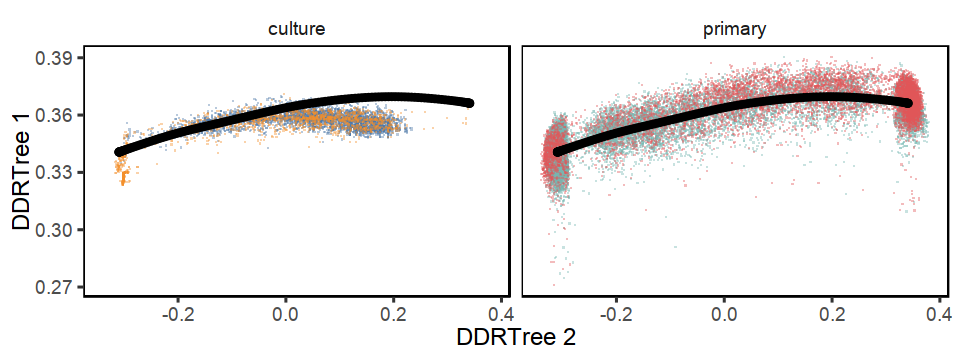

In [718]:
fig.size(3, 8)

with(joint, {
    idx_mm <- which(meta_data$source == "culture")
    idx_pr <- which(meta_data$source == "primary" & meta_data$cell_type %in% c("lining", "sublining"))
    ddr_Z %>% data.frame() %>% 
        cbind(meta_data[c(idx_pr, idx_mm), ]) %>% 
        dplyr::mutate(label = ifelse(source == 'culture', donor, disease)) %>% 
#         subset(!cell_type %in% c("blood", 'pericytes')) %>% 
        subset(!cell_type %in% c("blood")) %>% 
#         subset() %>% 
    # ddr_new %>% data.frame() %>% 
    #     cbind(meta_data[idx_mm, ]) %>% 
    #     cbind(tissue$meta_data %>% subset(cell_type %in% c('pericytes', "lining", "sublining"))) %>%
    #     cbind(tissue$meta_data %>% subset(cell_type %in% c("lining", "sublining"))) %>%
        ggplot(aes(-X2, X1)) + 
#         ggplot(aes(X1, X2)) + 
            geom_point(shape = ".", alpha = .4, aes(color = label)) + 
    #         geom_point(shape = ".", aes(color = 100 - time), alpha = .4) + 
    #         geom_point(shape = ".", aes(color = cell_type), alpha = .4) + 
#             geom_density_2d(aes(color = label)) + 
            geom_point(data = data.frame(t(tissue$ddrtree_res$Y))) + 
            theme_tufte(base_size = 14) + 
            theme(panel.background = element_rect()) + 
            labs(x = "DDRTree 2", y = "DDRTree 1") + 
    #         scale_color_gradient2(mid = "blue", high = "grey", midpoint = 0) + 
            guides(color = FALSE) + 
            scale_color_tableau() + 
            facet_wrap(~source) + 
    #         scale_y_continuous(position = "right") + 
            NULL    
})



In [719]:
with(joint, {
    idx_mm <- which(meta_data$source == "culture")
    idx_pr <- which(meta_data$source == "primary" & !is.na(meta_data$time))
    # idx_pr <- which(meta_data$source == "primary" & meta_data$cell_type %in% c("lining", "sublining"))

    length(idx_mm)
    length(idx_pr); nrow(tissue$ddrtree_res$Z)

    ## directed KNN: MM to Primary
    data_pr <- t(harmonyObj$Z_cos[, idx_pr])
    data_mm <- t(harmonyObj$Z_cos[, idx_mm])
    system.time({
        knn <- RANN::nn2(data_pr, data_mm, k = 30, eps = 0)
    })


    time_mm <- Reduce(rbind, lapply(1:nrow(knn$nn.idx), function(i) {
        nn_dist <- knn$nn.dists[i, ]
        nn_dist <- exp(-nn_dist / .1)
        nn_dist %<>% prop.table()
        nn_pseudotime <- meta_data[idx_pr, 'time'][knn$nn.idx[i, ]]
        sum(nn_dist * nn_pseudotime)
    }))

    joint$meta_data[idx_mm, "time"] <<- as.numeric(time_mm)    
})


### Project to Primary UMAP

In [721]:
with(joint, {
    idx_mm <- which(meta_data$source == "culture")
    idx_pr <- which(meta_data$source == "primary")

    length(idx_mm)
    length(idx_pr); nrow(tissue$umap_harmony)

    ## directed KNN: MM to Primary
    # data_pr <- V[idx_pr, ] %>% cosine_normalize_cpp(1)
    # data_mm <- V[idx_mm, ] %>% cosine_normalize_cpp(1)
    data_pr <- t(harmonyObj$Z_cos[, idx_pr])
    data_mm <- t(harmonyObj$Z_cos[, idx_mm])
    system.time({
        knn <- RANN::nn2(data_pr, data_mm, k = 30, eps = 0)
    })
    umap_new <- Reduce(rbind, lapply(1:nrow(knn$nn.idx), function(i) {
        ## make probability distribution from neighboring cells
        nn_dist <- knn$nn.dists[i, ]
        nn_dist <- exp(-nn_dist / .1)
        nn_dist %<>% prop.table()

        
#         tissue$umap_harmony[knn$nn.idx[i, ], ] %>% apply(2, median)
        
        ## average over UMAP coordinates
        tissue$umap_harmony[knn$nn.idx[i, ], ] %>% sweep(1, nn_dist, `*`) %>% colSums
    }))
    joint$umap_projected <<- rbind(tissue$umap_harmony, umap_new)
    
    
    labels_mm <- Reduce(rbind, lapply(1:nrow(knn$nn.idx), function(i) {
        nn_dist <- knn$nn.dists[i, ]
        nn_dist <- exp(-nn_dist / .1)
        nn_dist %<>% prop.table()
        nn_types <- meta_data[idx_pr, 'cell_type'][knn$nn.idx[i, ]]
        probs <- split(nn_dist, nn_types) %>% lapply(sum)
        if (max(as.numeric(probs)) < .8) {
            return("other")
        } else {
            return(names(which.max(probs)))
        }
    }))
    joint$meta_data[idx_mm, 'cell_type'] <<- as.character(labels_mm)     
})


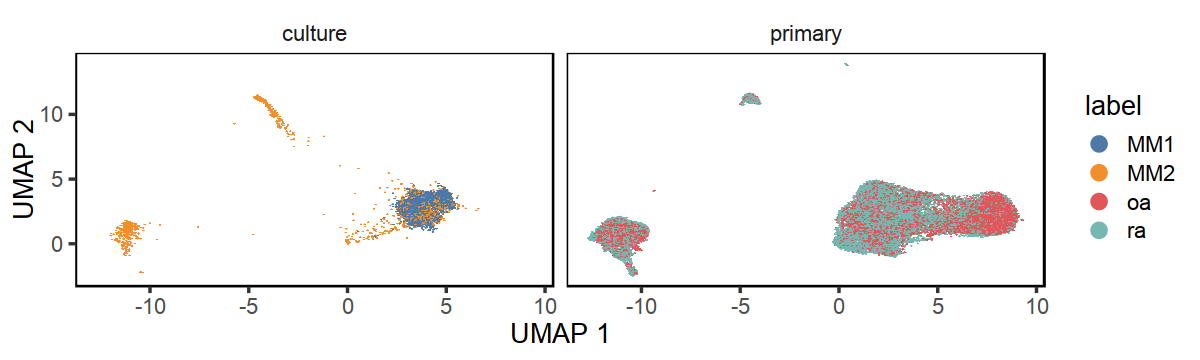

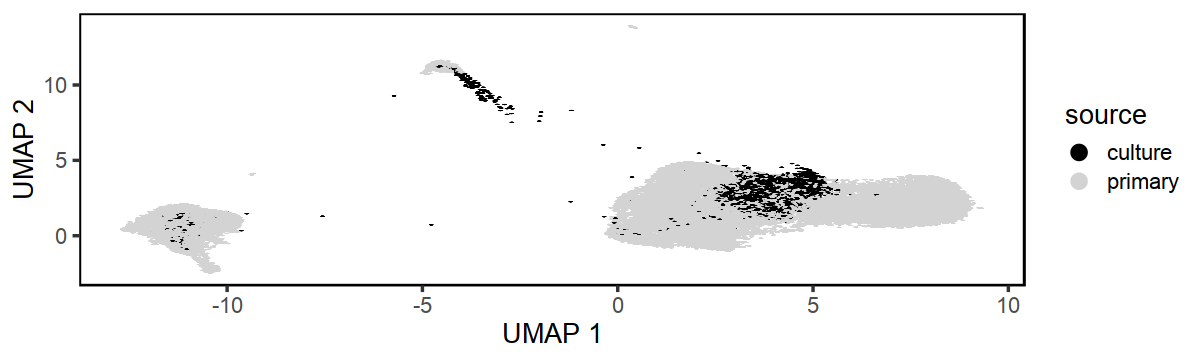

In [722]:
fig.size(3, 10)
with(joint, {
    plt <- umap_projected %>% 
        do_scatter(
            meta_data %>% dplyr::mutate(label = ifelse(source == 'culture', donor, disease)), 
            "label", pt_size = 4, no_guides = FALSE, 
    #         palette_use = c('culture' = 'black', 'primary' = 'lightgrey'), do_labels = FALSE) + 
            palette_use = tableau_color_pal()(10), do_labels = FALSE
        ) +
            facet_wrap(~source)
    plot(plt)
    
    umap_projected %>%
        do_scatter(meta_data, 'source', pt_size = 4, no_guides = FALSE,
                   palette_use = c('culture' = 'black', 'primary' = 'lightgrey'), do_labels = FALSE) 
    
})


## (CACHE)

In [723]:
saveRDS(joint, file.path(cachedir, "analysis_sc_tissue_mm.rds"))

# Ligand-Receptor Analysis

## DGE analysis in MM2

## DGE

In [495]:
joint$meta_data %>% subset(donor == 'MM2') %>% with(table(cell_type))

cell_type
    blood    lining     other pericytes sublining 
      302         2       380       273      1119 

In [496]:
# sum(is.na(tissue$meta_data$cell_type))
with(joint, {
    genes_use <- which(Matrix::rowSums(exprs_norm != 0) >= 5)
    idx_use <- which(meta_data$donor == 'MM2')
    cell_types <- ifelse(meta_data$cell_type == 'blood', 'blood', ifelse(meta_data$cell_type == 'pericytes', 'pericytes', 'other'))
    joint$markers_mm2 <<- wilcoxauc::fast_diff_exp(exprs_norm[genes_use, idx_use], factor(cell_types[idx_use]))
})


In [503]:
## Kevin's database

x <- fread("/data/srlab/ik936/NOTCH/data/ligand and receptors.csv")[, .(Symbol)]
get.ligand <- T
lig.rec.df <- data.frame()
for (i in 1:nrow(x)) {
  if (get.ligand) {
    ligand <- x[i, Symbol]
    get.ligand <- F
  } else if (x[i] != "") {
    receptor <- x[i, Symbol]
    lig.rec.df <- rbind(lig.rec.df, data.table(ligand = ligand, receptor = receptor))    
  } else {
    get.ligand <- T
  }
}
lr_pairs_kevin <- lig.rec.df %>%
  dplyr::filter(!ligand %in% c("", "-")) #%>%
  # dplyr::filter(ligand %in% bwhagg@var.genes) %>%
  # dplyr::filter(receptor %in% bwhagg@var.genes)

In [548]:
with(tissue, {    
    lr_pairs <- lr_pairs_kevin %>% subset(ligand %in% row.names(markers$fdr) & receptor %in% row.names(markers$fdr))
    tissue$lr_df_st <<- Reduce(
        rbind, 
        lr_pairs %>% 
            apply(1, function(x) {
                data.table(ligand = x[["ligand"]], receptor = x[["receptor"]], 
                           ligand_expr = markers$fdr[x[["ligand"]], "blood"], 
                           receptor_expr = markers$fdr[x[["receptor"]], "pericytes"],
                           ligand_pct = markers$pct_in[x[["ligand"]], "blood"], 
                           receptor_pct = markers$pct_in[x[["receptor"]], "pericytes"])
            })    
    ) 
})
    

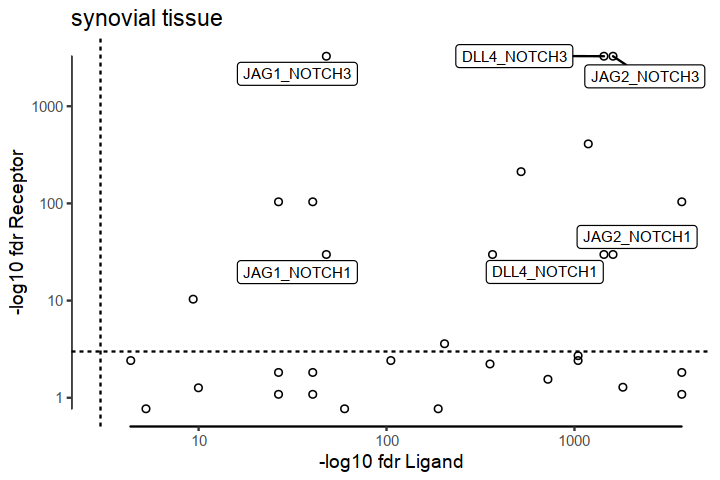

In [557]:
fig.size(4, 6)
tissue$lr_df_st %>% 
        subset(ligand_expr >= 0 & receptor_expr >= 0) %>% 
        ggplot(aes(ligand_expr, receptor_expr)) + geom_point(shape = 21) + 
        geom_vline(xintercept = 3, linetype = 2) + 
        geom_hline(yintercept = 3, linetype = 2) + 
        theme_tufte() + geom_rangeframe() + 
        geom_label_repel(data = . %>% subset(ligand_expr >= 10 & receptor_expr >= 10 & 
                                             ligand_pct > .1 & receptor_pct > .1), 
                         aes(label = sprintf("%s_%s", ligand, receptor)), size = 3) +
        labs(x = "-log10 fdr Ligand", y = "-log10 fdr Receptor", title = "synovial tissue") + 
        scale_x_log10() + scale_y_log10() + 
        NULL

# fig.size(4, 6)
# tissue$lr_df_st %>% 
#         subset(ligand_expr >= 0 & receptor_expr >= 0) %>% 
#         ggplot(aes(ligand_expr, receptor_expr)) + geom_point(shape = 21) + 
#         geom_vline(xintercept = 3, linetype = 2) + 
#         geom_hline(yintercept = 3, linetype = 2) + 
#         theme_tufte() + geom_rangeframe() + 
#         geom_label_repel(data = . %>% subset(ligand_expr >= 20 & receptor_expr >= 20),
# #                                              ligand_pct > .1 & receptor_pct > .1), 
#                          aes(label = sprintf("%s_%s", ligand, receptor)), size = 3) +
#         labs(x = "-log10 fdr Ligand", y = "-log10 fdr Receptor", title = "synovial tissue") + 
#         scale_x_log10() + scale_y_log10() + 
#         NULL

In [563]:
with(joint, {    
    lr_pairs <- lr_pairs_kevin %>% subset(ligand %in% row.names(markers_mm2$fdr) & receptor %in% row.names(markers_mm2$fdr))
    joint$lr_df_st <<- Reduce(
        rbind, 
        lr_pairs %>% 
            apply(1, function(x) {
                data.table(ligand = x[["ligand"]], receptor = x[["receptor"]], 
                           ligand_expr = markers_mm2$fdr[x[["ligand"]], "blood"], 
                           receptor_expr = markers_mm2$fdr[x[["receptor"]], "pericytes"],
                           ligand_pct = markers_mm2$pct_in[x[["ligand"]], "blood"], 
                           receptor_pct = markers_mm2$pct_in[x[["receptor"]], "pericytes"])
            })    
    ) 
})
    

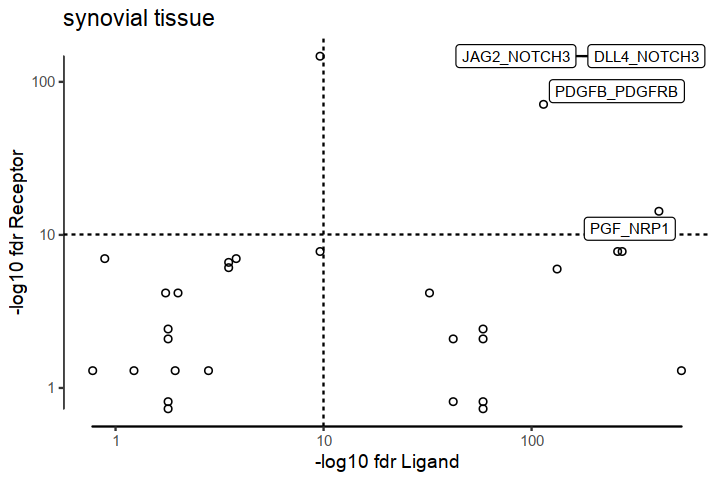

In [564]:
fig.size(4, 6)
joint$lr_df_st %>% 
        subset(ligand_expr >= 0 & receptor_expr >= 0) %>% 
        ggplot(aes(ligand_expr, receptor_expr)) + geom_point(shape = 21) + 
        geom_vline(xintercept = 10, linetype = 2) + 
        geom_hline(yintercept = 10, linetype = 2) + 
        theme_tufte() + geom_rangeframe() + 
        geom_label_repel(data = . %>% subset(ligand_expr >= 10 & receptor_expr >= 10 & 
                                             ligand_pct > .1 & receptor_pct > .1), 
                         aes(label = sprintf("%s_%s", ligand, receptor)), size = 3) +
        labs(x = "-log10 fdr Ligand", y = "-log10 fdr Receptor", title = "synovial tissue") + 
        scale_x_log10() + scale_y_log10() + 
        NULL

## (CACHE)

In [26]:
tissue %>% saveRDS(file.path(cachedir, "analysis_sc_tissue.rds"))
joint %>% saveRDS(file.path(cachedir, "analysis_sc_tissue_mm.rds"))

# Bulk Data

## Initialize matrices

In [188]:
data.dir <- "../data/raw/raw/Kevin_invitro_Sep25/"

exprs <- do.call(rbind, lapply(list.files(data.dir, pattern = ".genes.results"), function(fname) {
  fread(sprintf("%s/%s", data.dir, fname))[
    , .(gene_id, TPM, sample.id = gsub(".genes.*", "", fname))
    ]
}))

head(exprs)

gene_id,TPM,sample.id
ENSG00000000003.14,18.93,000008542569_A01
ENSG00000000005.5,7.45,000008542569_A01
ENSG00000000419.12,31.79,000008542569_A01
ENSG00000000457.13,5.31,000008542569_A01
ENSG00000000460.16,5.88,000008542569_A01
ENSG00000000938.12,0.00,000008542569_A01


In [189]:
gene.id.map <- fread("../data//CellRangerGeneIDMap.txt")
exprs.wide <- exprs %>%
  dplyr::mutate(id = gsub("\\.\\d*", "", gene_id)) %>%
  dplyr::inner_join(gene.id.map) %>%
  dplyr::select(symbol, sample.id, TPM) %>% 
  data.table
exprs.wide <- data.table(exprs.wide)[, .(TPM = sum(TPM)), by = .(sample.id, symbol)]
exprs.wide %<>% tidyr::spread(sample.id, TPM) %>% data.frame
rownames(exprs.wide) <- exprs.wide$symbol
exprs.wide <- exprs.wide[, 2:ncol(exprs.wide)]
colnames(exprs.wide) <- gsub("X\\d+_", "", colnames(exprs.wide))
exprs.wide <- exprs.wide[, setdiff(colnames(exprs.wide), c("A12", "F03", "F07", "B03"))] ## poor QC samples
exprs.wide <- log2(1 + exprs.wide)

ncol(exprs.wide)

Joining, by = "id"


[1] 92

In [190]:
## expressed in over 20 samples
genes.keep <- which(rowSums(exprs.wide > 0) > 20) %>% names
exprs.wide <- exprs.wide[genes.keep, ]

In [191]:
exprs.tidy <- exprs.wide %>% 
    tibble::rownames_to_column("symbol") %>% 
    tidyr::gather(sample.id, value, -symbol)

In [192]:
metadata <- fread("../data/raw/raw/Kevin_invitro_Sep25/metadata.csv")[, 1:8] %>% 
  dplyr::mutate(Column = gsub(" ", "0", sprintf("%2d", Column))) %>% 
  tidyr::unite(sample.id, c("Row", "Column"), sep = "") %>%
  dplyr::filter(!`sample.id` %in% c("A12", "F03", "F07", "B03")) %>%
  # dplyr::filter(`Cell type` != "CD146+") %>%
  # dplyr::mutate(`Cell type` = factor(gsub(" ", "", `Cell type`), levels = c("CD90-", "CD90+CD34-", "CD90+CD34+"))) %>%
  dplyr::mutate(`Cell type` = factor(gsub(" ", "", `Cell type`), levels = c("FLSline", "CD90-", "CD90+CD34-", "CD90+CD34+", "CD146+"))) %>%
  dplyr::mutate(condition = ifelse(condition %in% c("Day 7", "Day 8"), "Day7/8", condition)) %>% 
    data.frame

metadata$condition %>% unique

[1] "Fresh"  "Day7/8" "Day 14" "PBS"    "JAG1"   "DLL4"

In [648]:
bulk <- list()
bulk$metadata <- metadata
bulk$exprs.tidy <- exprs.tidy
bulk$exprs.wide <- exprs.wide
bulk %>% saveRDS(file.path(cachedir, "bulk_data.rds"))

## Map bulk samples to trajectory, UMAP, and time

In [277]:
idx_use <- which(tissue$meta_data$cell_type %in% c('lining', 'sublining'))
design <- model.matrix(~time + donor, tissue$meta_data[idx_use, ])
limma_res <- tissue$exprs_norm[, idx_use] %>% 
    limma::lmFit(design) %>% 
    limma::eBayes() %>% 
    limma::topTable(coef = 2, number = 1e4)



Warning message:
“Zero sample variances detected, have been offset away from zero”

In [634]:
with(bulk, {
    ## get SC vargenes    
    vargenes_df <- singlecellmethods::findVariableGenes(tissue$exprs_norm, tissue$meta_data$donor)
    var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])
    genes_use <- intersect(var_genes, row.names(exprs.wide))
#     genes_use <- limma_res %>% head(3e3) %>% row.names() %>% intersect(row.names(exprs.wide))    
    
#     samples_bulk <- metadata %>% subset(Experiment == 'Notch stimulation')
    samples_bulk <- metadata
    idx_sc <- which(tissue$meta_data$cell_type %in% c('lining', 'sublining'))
    
    data_bulk <- exprs.wide[genes_use, samples_bulk$sample.id] %>% as.matrix %>% cosine_normalize(2)
    data_sc <- tissue$exprs_norm[genes_use, idx_sc] %>% as.matrix %>% cosine_normalize(2)

    bulk$knn_stim <<- RANN::nn2(t(data_sc), t(data_bulk), k = 100, eps = 0)
})



### DDRTree + time

In [641]:
with(bulk, {
    k <- 100
    idx_sc <- which(tissue$meta_data$cell_type %in% c('lining', 'sublining'))
    
    ddr_new <- Reduce(rbind, lapply(1:nrow(knn_stim$nn.idx), function(i) {
        ## make probability distribution from neighboring cells
        nn_dist <- knn_stim$nn.dists[i, 1:k]
        nn_dist <- exp(-nn_dist / .1)
        nn_dist %<>% prop.table()

        ## average over UMAP coordinates
        tissue$ddrtree_res$Z[knn_stim$nn.idx[i, 1:k], ] %>% sweep(1, nn_dist, `*`) %>% colSums
#         tissue$ddrtree_res$Z[knn_stim$nn.idx[i, 1:k], ] %>% apply(2, median)
        
    }))
    bulk$ddr_stim <<- ddr_new    

    
    time_new <- Reduce(rbind, lapply(1:nrow(knn_stim$nn.idx), function(i) {
        nn_dist <- knn_stim$nn.dists[i, ]
        nn_dist <- exp(-nn_dist / .1)
        nn_dist %<>% prop.table()
        nn_pseudotime <- tissue$meta_data[idx_sc, 'time'][knn_stim$nn.idx[i, ]]
        sum(nn_dist * nn_pseudotime)
    }))

    bulk$metadata[, "time"] <<- as.numeric(time_new)    
    
})


###  UMAP

In [567]:
with(bulk, {
    ## get SC vargenes    
    idx_sc <- which(tissue$meta_data$cell_type %in% c('lining', 'sublining', 'pericytes'))
    
    vargenes_df <- singlecellmethods::findVariableGenes(tissue$exprs_norm[, idx_sc], tissue$meta_data$donor[idx_sc])
    var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])
    genes_use <- intersect(var_genes, row.names(exprs.wide))
    samples_bulk <- metadata
    
    data_bulk <- exprs.wide[genes_use, samples_bulk$sample.id] %>% as.matrix %>% cosine_normalize(2)
    data_sc <- tissue$exprs_norm[genes_use, idx_sc] %>% as.matrix %>% cosine_normalize(2)

    bulk$knn_umap <<- RANN::nn2(t(data_sc), t(data_bulk), k = 100, eps = 0)
})



In [568]:
with(bulk, {
    k <- 30
    idx_sc <- which(tissue$meta_data$cell_type %in% c('lining', 'sublining', 'pericytes'))
    umap_new <- Reduce(rbind, lapply(1:nrow(knn_stim$nn.idx), function(i) {
        ## make probability distribution from neighboring cells
        nn_dist <- knn_stim$nn.dists[i, 1:k]
        nn_dist <- exp(-nn_dist / .1)
        nn_dist %<>% prop.table()

        ## average over UMAP coordinates
        tissue$umap_harmony[idx_sc, ][knn_umap$nn.idx[i, 1:k], ] %>% sweep(1, nn_dist, `*`) %>% colSums
#         tissue$ddrtree_res$Z[knn_stim$nn.idx[i, 1:k], ] %>% apply(2, median)
        
    }))
    bulk$umap_harmony <<- umap_new
    

    
})


## Stim DGE

In [732]:
library(limma)
with(bulk, {
    design_mat <- metadata %>% subset(condition %in% c('PBS', 'JAG1'))
    bulk$dge_jag1 <<- exprs.wide[, design_mat$sample.id] %>% 
    #     limma::lmFit(model.matrix(~ (condition != "PBS") + Donor.cell.line, metadata)) %>% 
        limma::lmFit(model.matrix(~ (condition != "PBS") + Donor.cell.line, design_mat)) %>% 
        limma::eBayes() %>% 
        limma::topTable(coef = 2, number = 1e5) %>% 
        tibble::rownames_to_column("symbol") %>% 
        tibble::rowid_to_column("rank")    
    
    
    design_mat <- metadata %>% subset(condition %in% c('PBS', 'DLL4'))
    bulk$dge_dll4 <<- exprs.wide[, design_mat$sample.id] %>% 
    #     limma::lmFit(model.matrix(~ (condition != "PBS") + Donor.cell.line, metadata)) %>% 
        limma::lmFit(model.matrix(~ (condition != "PBS") + Donor.cell.line, design_mat)) %>% 
        limma::eBayes() %>% 
        limma::topTable(coef = 2, number = 1e5) %>% 
        tibble::rownames_to_column("symbol") %>% 
        tibble::rowid_to_column("rank")    

    
    design_mat <- metadata# %>% subset(condition %in% c('PBS', 'DLL4'))
    bulk$dge_both <<- exprs.wide[, design_mat$sample.id] %>% 
    #     limma::lmFit(model.matrix(~ (condition != "PBS") + Donor.cell.line, metadata)) %>% 
        limma::lmFit(model.matrix(~ (condition != "PBS") + Donor.cell.line, design_mat)) %>% 
        limma::eBayes() %>% 
        limma::topTable(coef = 2, number = 1e5) %>% 
        tibble::rownames_to_column("symbol") %>% 
        tibble::rowid_to_column("rank")    
    
})



## NOTCH3 activation score

In [123]:
bulk <- readRDS(file.path(cachedir, "bulk_data.rds"))

In [124]:
with(bulk, {
    genes_dll4 <- dge_dll4 %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) %>% 
        intersect(row.names(tissue$exprs_norm))
    genes_jag1 <- dge_jag1 %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) %>% 
        intersect(row.names(tissue$exprs_norm))
#     genes_both <- dge_both %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) %>% 
#         intersect(row.names(tissue$exprs_norm))
    genes_both <- union(genes_dll4, genes_jag1)

    .x <<- data.table(
        score_jag1 = Matrix::colSums(tissue$exprs_norm[genes_jag1, ]),
        score_dll4 = Matrix::colSums(tissue$exprs_norm[genes_dll4, ]),
        score_both = Matrix::colSums(tissue$exprs_norm[genes_both, ])
    ) %>% 
        cbind(tissue$meta_data)
    
})

In [127]:
head(.x)
dim(.x)

score_jag1,score_dll4,score_both,cell_id,donor,nUMI,nGene,percent_mito,disease,source,clusters,cell_type,time,cell_subtype
<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
2.786317,22.84597,22.84597,AAACCTGAGACAAAGG_BWH075,BWH075,3304,1265,0.06174334,ra,primary,2,lining,24.55933,lining
4.091484,14.75103,15.48555,AAACCTGAGACTGTAA_BWH075,BWH075,9223,2364,0.02060067,ra,primary,3,blood,NA,Venous
7.029027,31.98653,31.98653,AAACCTGAGGTAGCCA_BWH075,BWH075,5198,1789,0.05790689,ra,primary,1,sublining,97.77696,sublining
0.000000,17.05006,17.05006,AAACCTGCAATCTGCA_BWH075,BWH075,2957,1156,0.07203247,ra,primary,1,sublining,94.76058,sublining
6.182153,19.03585,21.89884,AAACCTGCATCGACGC_BWH075,BWH075,4506,1769,0.03284510,ra,primary,3,blood,NA,Venous
8.039745,23.51328,23.51328,AAACCTGCATTATCTC_BWH075,BWH075,4198,1448,0.01619819,ra,primary,2,lining,13.16606,lining


[1] 35153    14

In [129]:
tissue$score_notch <- .x$score_both

In [10]:
bin_95 <- function(data_df, xvar, yvars, num.bin) {
    data_df <- data.frame(data_df)
    x <- data_df[[xvar]]
    
    .breaks <- unique(quantile(x, probs=seq(0, 1, length.out=num.bin)))
    bin_means <- .5 * (head(.breaks, -1) + tail(.breaks, -1))
    bins_freq <- cut(x, .breaks, include.lowest=TRUE)
    levels(bins_freq) <- bin_means 
    xmeans <- lapply(split(x, as.integer(bins_freq)), mean) %>% as.numeric
    
    res_df <- Reduce(rbind, lapply(yvars, function(yvar) {
        y <- data_df[[yvar]]        
        ymeans <- lapply(split(y, as.integer(bins_freq)), mean) %>% as.numeric
        ysd <- lapply(split(y, as.integer(bins_freq)), sd) %>% as.numeric
        data.frame(xval = xmeans) %>% 
            cbind(
                Reduce(rbind, lapply(split(y, as.integer(bins_freq)), function(.x) quantile(.x, c(.05, .95)))) %>% 
                    data.frame() %>% 
                    dplyr::mutate(symbol = yvar)
            ) %>% 
            cbind(yval = ymeans, ysd = ysd)
             
    })) %>% data.frame()
    return(res_df)
}

## NOTCH activation score

In [403]:
exprs_amp <- readRDS("/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/filtered_log2tpm_lowinput_phase_1.rds")
meta_amp <- readRDS("/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/filtered_meta_lowinput_phase_1.rds")

In [404]:
meta_amp %<>% 
    subset(Cell.type == "Fibroblast" & QC..pass.fail. == "passed") %>% 
    identity()

In [405]:
meta_amp %<>% 
dplyr::inner_join(
    openxlsx::read.xlsx("/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/postQC_all_samples.xlsx", 1), 
    by = c("Donor.ID" = "Patient")
) %>% 
#     subset(disease_tissue != "RA-arthro") %>% 
    dplyr::mutate(status = ifelse(Mahalanobis > 20, "rich", "poor")) %>% 
    dplyr::mutate(status = factor(status, c("poor", "rich"))) %>% 
    dplyr::mutate(disease_tissue = factor(disease_tissue, c("OA-arthro", "RA-arthro", "RA-biopsy"))) %>% 
#     dplyr::mutate(disease_tissue = factor(disease_tissue, c("OA-arthro", "RA-biopsy"))) %>% 
    identity() 


exprs_amp <- exprs_amp[, meta_amp$Sample.ID]

In [422]:
bulk$meta_amp <- meta_amp
bulk$exprs_amp <- exprs_amp


# Background estimation

CAUTION: CHANGE THESE PATHS FOR YOUR SYSTEM!

Gather paths to raw expression matrices 

In [236]:
manifest <- list(
    # Primary tissue samples
    batch1 = list(dir.erisone = "/data/srlab/roche/Kevin-Wei/10xgenomics/2017-03-24/",
                  sample.names = c("BWH075", "BWH078")),
    batch2 = list(
        dir.erisone = "/data/srlab/roche/Kevin-Wei/10xgenomics/2017-02-10/",
        sample.names = c("BWH076CD45n")),
    batch3 = list(
        dir.erisone = "/data/srlab/ik936/bwh10x/180130_NB501431_0536_AH737VBGX3/",
        sample.names = c("BWH064CD45n", "OA180104A", "OA180108B")),
    batch4 = list(
        dir.erisone = "/data/srlab/ik936/bwh10x/180209_KW5270_10x_rawbcl/",
        sample.names = c("OA213CD45n", "OA214LCD45n", "RA174CD45n", "RA178CD45n_try2")),
    batch5 = list(
        dir.erisone = "/data/srlab/ik936/bwh10x/180521_KW5625_10x_rawbcl/",
        sample.names = c("OA180430_CD45n_BRI039", "OA180507_CD45n_BRI041")
    )
)
file.paths <- lapply(manifest, function(batch.list) {
    res <- file.path(batch.list$dir.erisone, batch.list$sample.names, 'outs/raw_gene_bc_matrices/hg19') 
    names(res) <- batch.list$sample.names
    res
}) %>% unlist()

names(file.paths) <- gsub('batch\\d.', '', names(file.paths))
names(file.paths) <- gsub('_try2', '', names(file.paths))
names(file.paths) <- gsub('_CD45n', '', names(file.paths))
names(file.paths) <- gsub('_BRI\\d+', '', names(file.paths))

In [342]:
donors <- unique(tissue$meta_data$donor)

## Assign cells to archetypes

In [349]:
## Set up empty assignment matrix
archetype_names <- c(unique(tissue$meta_data$cell_type), 'soup')
archetype_assignments <- matrix(NA, nrow = nrow(tissue$meta_data), ncol = length(archetype_names))
row.names(archetype_assignments) <- tissue$meta_data$cell_id
colnames(archetype_assignments) <- archetype_names
archetype_assignments <- as.data.frame(archetype_assignments)

In [350]:
dim(archetype_assignments)
archetype_assignments[1:5, 1:5]

[1] 35153     7

,lining,blood,sublining,pericytes,leukocytes
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
AAACCTGAGACAAAGG_BWH075,NA,NA,NA,NA,NA
AAACCTGAGACTGTAA_BWH075,NA,NA,NA,NA,NA
AAACCTGAGGTAGCCA_BWH075,NA,NA,NA,NA,NA
AAACCTGCAATCTGCA_BWH075,NA,NA,NA,NA,NA
AAACCTGCATCGACGC_BWH075,NA,NA,NA,NA,NA


In [351]:
# lapply(donors, function(donor_use) {
for(donor_use in donors) {
    message(donor_use)
    
    ## Get empty droplets
    exprs_raw <- read10x(file.paths[[donor_use]], donor_use)
    umis <- Matrix::colSums(exprs_raw)
    emptyDrops <- which(umis <= 10 & umis >= 1)
    soup <- rowSums(exprs_raw[, emptyDrops])
    soup <- split(as.numeric(soup), names(soup)) %>% lapply(sum) %>% unlist
    soup <- log1p(1e3 * (soup / sum(soup)))    
    
    ## Define archetypes
    idx_train <- which(tissue$meta_data$time < 15 | tissue$meta_data$time > 85 | 
                       tissue$meta_data$cell_type %in% c('pericytes', 'blood', 'leukocytes', 'lymph')) %>% 
                    intersect(which(tissue$meta_data$donor == donor_use))
    idx_test <- which(tissue$meta_data$donor == donor_use)

    message(length(idx_test))
    
    x <- split(idx_train, tissue$meta_data$cell_type[idx_train]) %>% lapply(function(idx) {
        Matrix::rowMeans(tissue$exprs_norm[, idx, drop = FALSE])
    })
    archetypes <- (Reduce(cbind, x))
    colnames(archetypes) <- names(x)
    archetypes <- cbind(archetypes, soup = soup[row.names(archetypes)]) %>% data.frame    

    ## Assign cells to archetypes via RBF kernel
    assignments <- cosine_kernel(tissue$exprs_norm[, idx_test], archetypes) %>% prop.table(1) %>% data.frame()
    row.names(assignments) <- colnames(tissue$exprs_norm[, idx_test])
    colnames(assignments) <- colnames(archetypes)

    if (any(is.na(assignments))) {
        stop('Found NA assignments')
    }
    
    ## Update the global assignment matrix
    archetype_names_sample <- intersect(archetype_names, colnames(assignments))
    archetype_assignments[idx_test, archetype_names_sample] <- assignments[, archetype_names_sample]
    
}

BWH075
3249
BWH078
2121
BWH076CD45n
2447
BWH064CD45n
4454
OA180104A
618
OA180108B
2695
OA213CD45n
4759
OA214LCD45n
4544
RA174CD45n
3368
RA178CD45n
2451
OA180430
1823
OA180507
2624


In [364]:
archetype_assignments[is.na(archetype_assignments)] <- 0

## Also try to classify barcodes enriched in non-cells (>100 UMIs)

In [586]:
soup_assignment <- matrix(NA, ncol = length(archetype_names), nrow=0)
colnames(soup_assignment) <- archetype_names
soup_assignment <- as.data.frame(soup_assignment)

meta_soup <- data.table(matrix(NA, nrow = 0, ncol = 3))
colnames(meta_soup) <- c('cell_id', 'nUMI', 'donor')
meta_soup

cell_id,nUMI,donor
<lgl>,<lgl>,<lgl>


In [587]:
for(donor_use in donors) {
    message(donor_use)
    
    ## Get empty droplets
    exprs_raw <- read10x(file.paths[[donor_use]], donor_use)
    umis <- Matrix::colSums(exprs_raw)
    emptyDrops <- which(umis <= 10 & umis >= 1)
    soup <- rowSums(exprs_raw[, emptyDrops])
    soup <- split(as.numeric(soup), names(soup)) %>% lapply(sum) %>% unlist
    soup <- log1p(1e3 * (soup / sum(soup)))    
    
    ## Get "soup" droplets with >100 UMIs
    exprs_raw <- read10x(file.paths[[donor_use]], donor_use)
    umis <- Matrix::colSums(exprs_raw)
    idx_soup <- which(umis >= 100 & umis <= 300)
    exprs_soup <- exprs_raw[row.names(tissue$exprs_norm), idx_soup] %>% 
        normalizeData(scaling_factor = 1e4, method = 'log')
    
    meta_new <- data.table(cell_id = colnames(exprs_soup), nUMI = umis[idx_soup], donor = donor_use)
    meta_soup <- rbind(meta_soup, meta_new)
    
    
    ## Define archetypes
    idx_train <- which(tissue$meta_data$time < 15 | tissue$meta_data$time > 85 | 
                       tissue$meta_data$cell_type %in% c('pericytes', 'blood', 'leukocytes', 'lymph')) %>% 
                    intersect(which(tissue$meta_data$donor == donor_use))
    idx_test <- which(tissue$meta_data$donor == donor_use)
    
    x <- split(idx_train, tissue$meta_data$cell_type[idx_train]) %>% lapply(function(idx) {
        Matrix::rowMeans(tissue$exprs_norm[, idx, drop = FALSE])
    })
    archetypes <- (Reduce(cbind, x))
    colnames(archetypes) <- names(x)
    archetypes <- cbind(archetypes, soup = soup[row.names(archetypes)]) %>% data.frame    

    ## Assign cells to archetypes via RBF kernel
    assignments <- cosine_kernel(exprs_soup, archetypes) %>% prop.table(1) %>% data.frame()
    row.names(assignments) <- colnames(exprs_soup)
    colnames(assignments) <- colnames(archetypes)
    
    if (any(is.na(assignments))) {
        stop('Found NA assignments')
    }    
    
    ## Update the global assignment matrix
    archetype_names_sample <- intersect(archetype_names, colnames(assignments))
    assignments_full <- matrix(NA, nrow = nrow(assignments), ncol = length(archetype_names)) %>% 
        as.data.frame()
    colnames(assignments_full) <- archetype_names
    assignments_full[, archetype_names_sample] <- assignments[, archetype_names_sample]
    soup_assignment <- rbind(soup_assignment, assignments_full)
}

soup_assignment[is.na(soup_assignment)] <- 0
meta_soup$assign <- colnames(soup_assignment)[apply(soup_assignment, 1, which.max)]

BWH075
BWH078
BWH076CD45n
BWH064CD45n
OA180104A
OA180108B
OA213CD45n
OA214LCD45n
RA174CD45n
RA178CD45n
OA180430
OA180507


In [661]:
tissue$soup_meta <- meta_soup
tissue$soup_assign <- soup_assignment

# Mural cells

## Plot markers

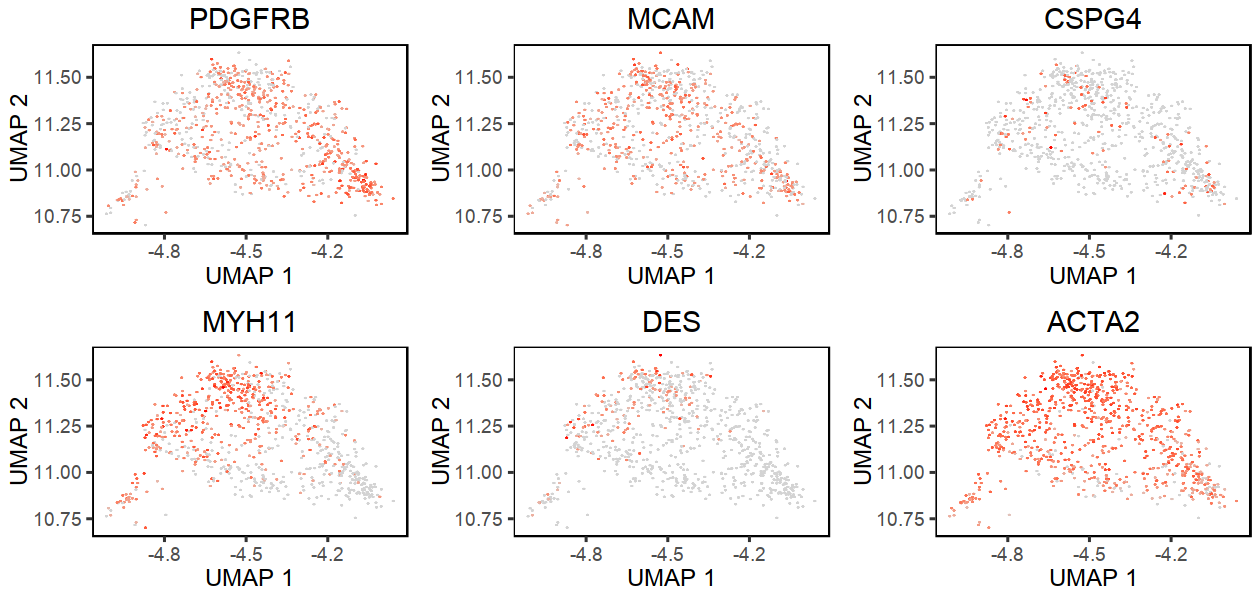

In [370]:
# features <- paste0('Notch', 1:4)
features <- c('PDGFRB', 'MCAM', 'CSPG4', 'MYH11', 'DES', 'ACTA2')

fig.size(5, 10.5)
with(tissue, {
    idx <- umap_harmony[, 2] > 7 & umap_harmony[, 2] < 12
    (plt <- plotFeatures(exprs_norm[, idx], umap_harmony[idx, ], order_by_expression = FALSE, no_guide = TRUE, w = 4 * 1, h = 3 * 1,
                 features, nrow = 2, qlo = 0, qhi = 1, pt_shape = 16, color_high = 'red'))
#     ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/human_mural_cell_markers.pdf', plot = plt, device = "pdf", 
#            dpi = 300, width = 10.5, height = 5, useDingbats = FALSE)  
})




## Subclusters

In [432]:
library(singlecellmethods)
# idx_mural <- which(tissue$umap_harmony[, 2] > 7 & tissue$umap_harmony[, 2] < 12)
idx_mural <- which(tissue$meta_data$cell_type == 'pericytes')
message(length(idx_mural))

snn_mural <- buildSNN_fromFeatures(t(tissue$Z_cos[, idx_mural]), 0, 10)
ids_mural <- leidenCluster(
    snn_mural, c(.2, .045), min_cluster_size = 10, verbose = TRUE, 
    pythondir = "/PHShome/ik936/anaconda3/bin/python")    

apply(ids_mural, 2, table)

778
Resolution 0.200000 yielded 8 clusters
Resolution 0.045000 yielded 3 clusters


$`res_2.0000e-01`

  1   2   3   4   5   6   7   8 
254 153 103  88  87  30  29  19 

$`res_4.5000e-02`

  1   2   3 
453 302  23 


In [433]:
library(presto)

In [434]:
# dge <- wilcoxauc(tissue$exprs_norm[, idx_mural], ids_mural$`res_5.0000e-01`)
# dge <- wilcoxauc(tissue$exprs_norm[, idx_mural], ids_mural$`res_2.0000e-01`)
dge <- wilcoxauc(tissue$exprs_norm[, idx_mural], ids_mural$`res_4.5000e-02`)

In [435]:
# fig.size(2.5, 8)
# dge %>% 
#     subset(feature %in% c('PDGFRB', 'MCAM', 'CSPG4')) %>% 
#     ggplot(aes(feature, group, fill = auc)) + 
#         geom_tile() + 
#         scale_fill_gradient2_tableau() + 
# dge %>% 
#     subset(feature %in% c('MYH11', 'DES', 'ACTA2')) %>% 
#     ggplot(aes(feature, group, fill = auc)) + 
#         geom_tile() + 
#         scale_fill_gradient2_tableau() + 
#         NULL


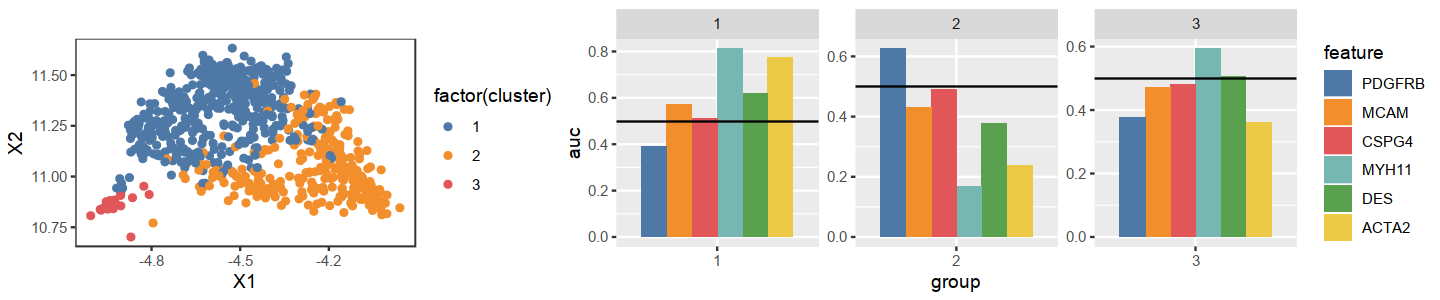

In [436]:
fig.size(2.5, 12)
tissue$umap_harmony[idx_mural, ] %>% 
    data.frame() %>% 
#     cbind(cluster = ids_mural$`res_5.0000e-01`) %>% 
    cbind(cluster = ids_mural$`res_4.5000e-02`) %>% 
    subset(!is.na(cluster)) %>% 
    ggplot(aes(X1, X2, color = factor(cluster))) + 
#         geom_point(shape = '.') + 
        geom_point() + 
        theme_test() + 
        scale_color_tableau() + 
dge %>% 
#     subset(feature %in% c('PDGFRB', 'MCAM', 'CSPG4')) %>% 
    subset(feature %in% c('PDGFRB', 'MCAM', 'CSPG4', 'MYH11', 'DES', 'ACTA2')) %>% 
    dplyr::mutate(feature = factor(feature, c('PDGFRB', 'MCAM', 'CSPG4', 'MYH11', 'DES', 'ACTA2'))) %>% 
    ggplot(aes(group, auc, fill = feature)) + 
#     ggplot(aes(feature, auc, fill = group)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        geom_hline(yintercept = .5) + 
        scale_fill_tableau() + 
        facet_wrap(~group, scales = 'free', nrow = 1) + 
plot_layout(widths = c(1, 2))


## Save labels

In [443]:
# tissue$meta_data$cell_subtype[idx_mural, ] <- tissue$meta_data$cell_subtype
tissue$meta_data$cell_subtype[idx_mural] <-case_when(
    ids_mural$`res_4.5000e-02` == 1 ~ 'VSMC',
    ids_mural$`res_4.5000e-02` == 2 ~ 'Pericyte',
    ids_mural$`res_4.5000e-02` == 3 ~ 'VSMC'
)

In [130]:
tissue %>% saveRDS(file.path(cachedir, "analysis_sc_tissue.rds"))

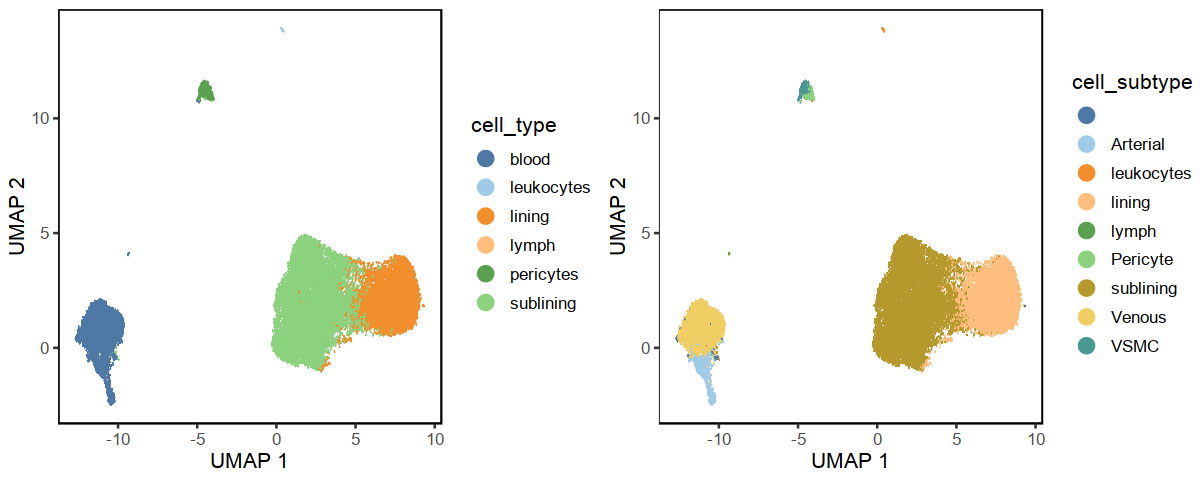

In [444]:
fig.size(4, 10)
with(tissue, {
    do_scatter(umap_harmony, meta_data, 'cell_type', pt_size = 4, no_guides = FALSE,
                              palette_use = tableau_color_pal('Tableau 20')(12), do_labels = FALSE) + 
    do_scatter(umap_harmony, meta_data, 'cell_subtype', pt_size = 4, no_guides = FALSE,
                              palette_use = tableau_color_pal('Tableau 20')(12), do_labels = FALSE) + 
    NULL    
#     ggsave('/data/srlab/ik936/NOTCH/paper/figures_supp/umap_batch.pdf', device = "pdf", 
#            dpi = 300, width = 10, height = 4, useDingbats = FALSE)    
})



# CDH11

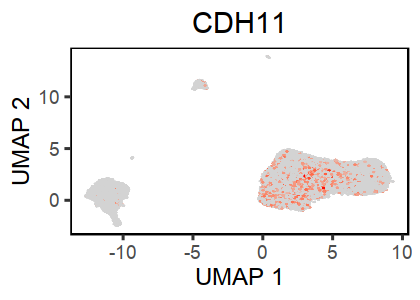

In [831]:
# features <- paste0('Notch', 1:4)
features <- c('CDH11')

fig.size(2.5, 3.5)
with(tissue, {
    plotFeatures(exprs_norm, umap_harmony, order_by_expression = FALSE, no_guide = TRUE, w = 4 * 1, h = 3 * 1,
                 features, nrow = 1, qlo = 0, qhi = 1, pt_shape = 16, color_high = 'red')
})



In [818]:
markers <- c('CDH11')
with(tissue, {
    idx_use <- which(meta_data$cell_type %in% c("lining", "sublining"))
    markers <- c('CDH11')
    ldata <<- data.frame(time = meta_data[idx_use, "time"], t(as.matrix(exprs_norm[markers, idx_use, drop = FALSE]))) %>% 
    bin_95("time", markers, 1e2)
})


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


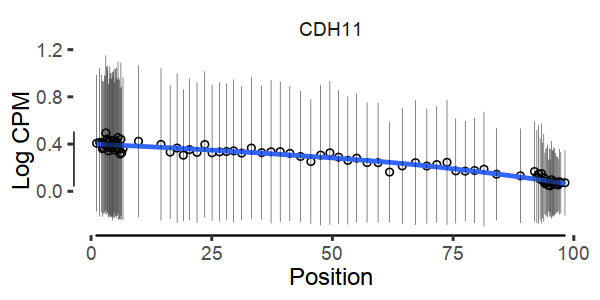

In [833]:
fig.size(2.5, 5)
(ldata %>% 
    ggplot(aes(100 - xval, yval)) + 
         geom_point(shape = 21) + 
#          geom_point(shape = ".") + 
        geom_smooth() + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .1) +
        facet_wrap(~symbol, scales = "free_y", nrow = 1) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
        labs(y = "Log CPM", x = "Position")
)    


# ggsave('/data/srlab/ik936/NOTCH/paper/figure1/pseudotime_markers.pdf', plot = plt1$pseudotime_markers, device = "pdf", 
#        dpi = 300, width = 5, height = 2.5, useDingbats = FALSE)

# Endothelial subsets

In [ ]:
library(singlecellmethods)
idx_ec <- which(tissue$meta_data$cell_type == 'blood')
message(length(idx_ec))
snn_ec <- buildSNN_fromFeatures(t(tissue$Z_cos[, idx_ec]), 0, 30)
ids_ec <- leidenCluster(
    snn_ec, c(.05, .03, .04, .02), min_cluster_size = 10, verbose = TRUE, 
    pythondir = "/PHShome/ik936/anaconda3/bin/python")    

In [443]:
apply(ids_ec, 2, table)

$`res_5.0000e-02`

   1    2    3    4    5 
5693  735  498   63   30 

$`res_3.0000e-02`

   1    2    3 
6454  519   42 

$`res_4.0000e-02`

   1    2    3    4    5 
5811  655  492   46   14 

$`res_2.0000e-02`

   1    2    3 
6509  493   16 


In [438]:
markers <- wilcoxauc(tissue$exprs_norm[, idx_ec], ids_ec[, 1])

In [439]:
top_markers(markers)

rank,1,2,3,4,5
<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,DARC,SPARC,SRP14,COL1A2,LGALS1
2,ADIRF,COL4A1,SRGN,BGN,IGFBP5
3,RPS18,COL15A1,CXCL12,LUM,TMSB4X
4,RPL10,RGCC,SLC9A3R2,SERPINF1,S100A6
5,RPL34,A2M,IFI27,COL3A1,PALLD
6,RPS14,COL4A2,GLUL,DCN,CD59
7,CD74,PLVAP,PODXL,COL6A2,ACKR3
8,RPL32,CALCRL,GJA4,WISP2,CD109
9,CLU,VWA1,ICAM2,COL6A3,HYAL2


## GSEA

### Define signatures using Human genes

In [202]:
ortho <- fread('/data/srlab/ik936/NOTCH/data/human_mouse_dict.csv') 
head(ortho)

HomoloGene ID,human,mouse
<int>,<chr>,<chr>
3,ACADM,Acadm
5,ACADVL,Acadvl
6,ACAT1,Acat1
7,ACVR1,Acvr1
9,SGCA,Sgca
12,ADSL,Adsl


In [144]:
endo_markers <- fread('/data/srlab/ik936/NOTCH/data/revisions/nature25739-s2.csv', header = TRUE, skip = 1) %>% 
    dplyr::select(gene = genes, lfc_AvV = aEC.vs.vEC.logFC, p_AvV = aEC.vs.vEC.PValue,
                 lfc_AvC = aEC.vs.capilEC.logFC, p_AvC = aEC.vs.capilEC.PValue,
                 lfc_VvC = vEC.vs.capilEC.logFC, p_VvC = vEC.vs.capilEC.Pvalue) %>% 
    tidyr::gather(key, val, -gene) %>%
    tidyr::separate(key, c('key', 'test'), by = '_') %>% 
    tidyr::spread(key, val) %>% 
    subset(p < .001) %>% 
    dplyr::select(-p)
    
    

endo_markers %>% nrow
endo_markers %>% head
data.table(endo_markers)[, .N, by = test]

[1] 1635

,gene,test,lfc
1,11-Sep,AvC,1.29
2,11-Sep,AvV,0.93
4,1500004A13Rik,AvC,1.80
6,1500004A13Rik,VvC,1.92
17,1700025G04Rik,AvV,3.61
28,1700066B19Rik,AvC,-2.13


test,N
AvC,636
AvV,555
VvC,444


In [434]:
genesets <- list(
    arterial = endo_markers %>%
        subset(lfc > 1) %>% 
        dplyr::inner_join(ortho, by = c('gene' = 'mouse')) %>% 
        with(human) %>% 
        intersect(row.names(tissue$exprs_norm)),
    venous = endo_markers %>% 
        subset(lfc < -1) %>% 
        dplyr::inner_join(ortho, by = c('gene' = 'mouse')) %>% 
        with(human)  %>% 
        intersect(row.names(tissue$exprs_norm))
)


In [435]:
lapply(genesets, length)

$arterial
[1] 253

$venous
[1] 181

### Do enrichment for each cluster

In [440]:
library(fgsea)

gsea_res <- split(1:nrow(markers), markers$group) %>% lapply(function(idx) {    
    x <- markers[idx, ] %>% 
        dplyr::arrange(auc) %>% 
        dplyr::select(feature, auc)
    stats <- x$auc
    names(stats) <- x$feature
    fgsea(genesets, stats, 1e4)
})


Warning message in fgsea(genesets, stats, 10000):
“There are ties in the preranked stats (27.28% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”Warning message in fgsea(genesets, stats, 10000):
“There are ties in the preranked stats (30.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”Warning message in fgsea(genesets, stats, 10000):
“There are ties in the preranked stats (33.33% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”Warning message in fgsea(genesets, stats, 10000):
“There are ties in the preranked stats (43.85% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”Warning message in fgsea(genesets, stats, 10000):
“There are ties in the preranked stats (53.79% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”

In [441]:
gsea_res

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
arterial,0.0002943774,0.0005887548,-0.21184075,-4.052486,0,253,"CXCL12 , IGFBP3 , TSC22D1 , TIMP3 , HEY1 , GJA4 , EFNB2 , GLUL , COL18A1 , S100A4 , STOM , CDH13 , ARL15 , SEMA3G , DLL4 , MCAM , PLCB1 , EMP3 , NR4A1 , FBLN5 , EMP1 , JAG2 , RCAN2 , TM4SF1 , AIF1L , TSPAN2 , LAPTM5 , ATP13A3 , TMEM47 , IVNS1ABP, THSD7A , APOLD1 , TPPP3 , TMEM178A, LTBP4 , MMP14 , UNC5B , ALPL , SSUH2 , GJA5 , CYR61 , MSX1 , FBN1 , ATP2B4 , CPM , SSFA2 , FSTL1 , ATP2A3 , ITGA9 , OAF , FAM198B , LTBP1 , TMEM100 , GJA1 , IQCK , CXCR4 , STC1 , ASPN , TBXA2R , SPRY4 , MRC2 , GPRC5B , COL14A1 , PLK2 , SERPINF1, GADD45G , SH2B3 , CD300LG , SYT11 , LOX , CCND2 , TRIM2 , SMARCA2 , ZEB2 , SH3PXD2B, CDK19 , SGCE , NCALD , GCNT1 , AXL , RASD1 , ECM2 , ANTXR1 , HEY2 , GADD45B , EPSTI1 , GCNT2 , CD1D , PDGFRA , EGR3 , MAP1A , KCNN4 , SLC2A10 , FCHSD2 , DCLK1 , FEZ1 , CDO1 , TPST1 , SEMA6D"
venous,0.0916561315,0.0916561315,0.09677385,1.441233,579,181,"CD74 , PRCP , VWF , HAPLN3 , ACTN1 , NR2F2 , ICAM1 , IL1R1 , BMP4 , NET1 , CYSLTR1, SEMA6A , FCGRT , NBL1 , NAMPT , SLC40A1, ST6GAL1, PTGDS , NDUFA8 , NRP2 , ABCG1 , FLRT2 , BST1"
pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
arterial,0.0007572316,0.001514463,0.13092509,2.273986,4,253,"TSC22D1 , COL18A1 , CDH13 , IGFBP3 , CXCL12 , FAM198B , IVNS1ABP, MCAM , PLCB1 , RCAN2 , TIMP3 , OAF , TPPP3 , EFNB2 , EMP1 , GJA1 , MMP14 , LAPTM5 , CPM , FSTL1 , NR4A1 , JAG2 , SPRY4 , DLL4 , ATP2B4 , HEY1 , CXCR4 , S100A4 , CTHRC1 , CCND2 , TBXA2R , UNC5B , SH2B3 , ITGA9 , STOM , APOLD1 , TMEM255B, DPYSL3 , GADD45G , STC1 , TMEM47 , PLK2 , LOX , ARL15 , IQCK"
venous,0.0842911877,0.084291188,-0.08882278,-1.441999,307,181,"CD74 , HAPLN3 , NR2F2 , ICAM1 , ACTN1 , IL1R1 , BMP4 , PRCP , VWF , NET1 , NBL1 , SEMA6A , PTGDS , ANXA2 , SLC40A1 , CYSLTR1 , BST1 , NAMPT , ABCG1 , SYT1 , ATP8A1 , FAM221A , SPINT2 , SLC38A5 , ST6GAL1 , PLXDC2 , CPE , PCOLCE , HDHD3 , GATM , AJUBA , MARK1 , GPRC5C , RNASE4 , SGCA , TMEM98 , FLRT2 , LAMA2 , HSPA2 , F5 , ADK , SPAG8 , C1orf226, ALDH1A1 , TRIB2 , ART3 , LBP , CTSW , RRAD , RND2 , ABCA9 , ICOSLG , NCAM1 , IRF5 , NSG1"
pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
arterial,0.0001443418,0.0002886836,0.30112070,5.144049,0,253,"CXCL12 , GLUL , GJA4 , HEY1 , IGFBP3 , TM4SF1 , STOM , EFNB2 , TIMP3 , SEMA3G , ARL15 , LTBP4 , FBLN5 , TSPAN2 , ATP13A3 , S100A4 , AIF1L , TMEM178A, TSC22D1 , EMP3 , DLL4 , GJA5 , THSD7A , SSUH2 , BTG2 , JAG2 , TMEM47 , ALPL , CYR61 , NR4A1 , MSX1 , SSFA2 , ATP2A3 , APOLD1 , LAPTM5 , EMP1 , UNC5B , TMEM100 , FBN1 , COL18A1 , SYT11 , PLCB1 , IQCK , GPRC5B , EGR1 , LTBP1 , GCNT1 , BMX , CDH13 , GADD45B , FOS , ITGA9 , RCAN2 , MCAM , FBLN2 , CDK19 , TRIM2 , CD300LG , HEY2 , ATP2B4 , EPSTI1 , CPM , GCNT2 , PLK2 , STC1 , KCNN4 , ZEB2 , SH3PXD2B, SGCE , SMARCA2 , ASPN , SLC45A4 , RASD1 , FHL1 , PLCL1 , GADD45G , PLEKHB1 , MRC2 , TBXA2R , PRODH , FEZ1 , KDM6B , DLGAP1 , SLC12A5 , NCALD , CXCR4 , PLD1 , FCHSD2 , GPRC5A , DCLK1 , DDR1 , SNCAIP , DKK2 , PALLD , HR , AXL , ECM2 , EGFL8 , CD1D , CDO1 , ARAP1 , ANTXR1 , MMP14 , TPST1 , GPC6 , LRRC32 , ARNTL2 , COL8A1 , MAP1A , PAPSS2 , EGR3 , CPT1C , BMPR1A , BMPER , EFNA5 , PID1 , SH2B3 , SEMA4B , COL14A1 , SVEP1 , MAB21L2 , BRIP1 , TGFB2 , ELOVL4 , GPER1 , PRUNE2 , COL4A4 , SUSD2 , CACNA1D , ARHGEF25, NOS1 , GUCY1A2 , SNX33 , RBPMS2 , TOM1L1 , GLRB , CHAC1 , SLC2A10"


In [442]:
lapply(gsea_res, function(x) {
    a <- subset(x, pathway == 'arterial') %>% with(ES)
    v <- subset(x, pathway == 'venous') %>% with(ES)
    if (a < 0 & v > 0) {
        return('Venous')
    } else if (a > 0 & v < 0) {
        return('Arterial')
    } else {
        return('Intermediate')
    }
})

$`1`
[1] "Venous"

$`2`
[1] "Arterial"

$`3`
[1] "Arterial"

$`4`
[1] "Intermediate"

$`5`
[1] "Intermediate"

In [277]:
tissue$meta_data$cell_subtype <- tissue$meta_data$cell_type
tissue$meta_data$cell_subtype[idx_ec] <- case_when(
    ids_ec[, 1] == 1 ~ 'Venous', 
    ids_ec[, 1] == 2 ~ 'Arterial', 
    ids_ec[, 1] == 3 ~ 'Arterial', 
    ids_ec[, 1] == 4 ~ '', 
    ids_ec[, 1] == 5 ~ ''
)